<h1 style='color:skyblue; text-align:center'> Plotting Spectrophotometric Data</h1>

<h2 style='color:lightblue; text-align:center'> Setting up libraries etc</h2>

In [1]:
## Plots the time evolition of triplet lifetime. PartWise analysis.
# from time import perf_counter
# t0 = perf_counter()
# import sys
import numpy as np
import pandas as pd
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
# from scipy.signal import find_peaks
from os import path
from glob import glob
# import os
# import argparse
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from iminuit import Minuit
# from iminuit.cost import LeastSquares
# from iminuit.cost import BinnedNLL
from iminuit.cost import ExtendedBinnedNLL
from scipy.optimize import curve_fit
from scipy.stats import anderson_ksamp

In [2]:
rng = np.random.default_rng(1)

In [3]:
%matplotlib ipympl

In [4]:
## ----------------------------------- matplotlib RC etc -----------------------------------------
# rc('figure', autolayout=True, figsize=[10, 6], dpi=75, titlesize=20 )
rc('figure', figsize=[10, 6], dpi=75, titlesize=20 )
rc('font', family='monospace')
rc('axes', titlesize=20, titleweight='heavy', labelsize=16, labelweight='bold')
rc(('xtick', 'ytick'), labelsize = 18)
rc('legend', fontsize=24)
rc('lines', linewidth=2.5)
rc('mathtext', default = 'regular')
rc('xtick.minor', visible = False, size = 6)
rc('ytick.minor', visible = True, size = 8)
# plt.rcParams['figure.constrained_layout.use'] = True
# rc('axes.formatter', limits=[-1, 1])
np.set_printoptions(formatter={'float': lambda x: f"{x:10.4g}"})

In [5]:
# rc('figure.constrained_layout', use=False) # doesnt work

In [6]:
## ----------------------------------------- directory -----------------------------------------
output_dir = '/home/sarthak/my_projects/argset/'
data_dir = '/home/sarthak/my_projects/argset/data/spectrophotometer_measurements/2025-01-30/'
# test_filename = 'pen_argset_A_centre_front.txt'

<h2 style='color:lightblue; text-align:center;'> function definitions </h2>

In [165]:
# from scipy.stats import shapiro


def f_gauss(x, f_mean, f_sigma, f_k):
    return f_k*(1/(f_sigma*np.sqrt(2*np.pi)))*np.exp(-0.5*((x-f_mean)/f_sigma)**2)

def red_chisq(f_obs, f_exp, fittedparameters):
    chisqr = np.sum((f_obs - f_exp)**2 / f_exp)
    ndf = f_obs.shape[0]
    return chisqr/(ndf -fittedparameters.shape[0])

def save_plot(fig:matplotlib.figure.Figure, file_name: str):
    fig.savefig(path.join(output_dir, f'{file_name}.pdf'))

def calc_pvalue(data_ls, minuit_obj):
    # res = shapiro(np.array(data_ls))
    # p_value = res.pvalue
    simulated_data = rng.normal(minuit_obj.values[0], minuit_obj.values[1], size=len(data_ls))
    p_value = anderson_ksamp([np.array(data_ls), simulated_data]).significance_level;
    print(f"Adjusted p-value: {p_value:.2f}")
    # print(f"Adjusted p-value: {p_value:.6f}")
    return p_value

def create_fig_with_inset(fig_number:int):
    # cm = 1/2.54
    fig, ax = plt.subplots(num=fig_number, figsize=(14.0, 11.0), dpi=150);
    ax.grid()
    # ax.set_ylim(-500, 400)
    # ax.set_ylim(0, 400)
    ax.set_ylim(0, 500)
    ax.set_xlim(185, 600)
    ax.set_xlabel('Wavelength [nm]', fontsize=20)
    ax.set_ylabel('Reflectance + fluorescence yield [%]', fontsize=20)
    ax_inset = inset_axes(ax, width="45%", height="45%", loc='center',
                        bbox_to_anchor=(-0.14, 0.22, 1, 1), 
                        bbox_transform=ax.transAxes);
    ax_inset.tick_params(axis='x', rotation=-15)
    # ax_inset.set_ylim(80, 160)
    ax_inset.set_ylim(100, 250)
    ## ax_inset.set_ylim(0, 400)
    ax_inset.set_xlim(185, 200)
    ax_inset.grid()
    return fig, ax, ax_inset

def add_line(fig, ax, ax_inset, datafile:pd.DataFrame, line_label:str, colorstr:str='magenta'):
    ax.plot(datafile['wavelength'], datafile['R'], linestyle='-', color=colorstr, label=line_label)
    ax_inset.plot(datafile['wavelength'], datafile['R'], linestyle='-', color=colorstr)
    ax.legend(fontsize=18)

In [8]:
## ----------------------------------------- Pattern search -----------------------------------------
filename_pattern = '*.txt'
datafile_path_ls = glob(path.join(data_dir, filename_pattern))

for index, file_path in enumerate(datafile_path_ls):
    print(index, file_path.split(sep='/')[-1])

0 pen_argset_A_back_corner1_01_pressed.txt
1 no_sample_attempt1.txt
2 pen_teonex_Q51_old_spot1.txt
3 pen_argset_A_front_corner3.txt
4 pen_argset_A_front_corner4.txt
5 pen_argset_otherB_front_spot1.txt
6 2pac_esrtpb_3.txt
7 2pac_esrtpb_4.txt
8 PEN_Q53_UZH_spot2.txt
9 pen_argset_A_front_corner3_02.txt
10 pen_argset_C_TopSurface_centre.txt
11 pen_argset_C_BottomSurface_corner2.txt
12 pen_argset_A_TopSurface_corner1.txt
13 PEN_Q51_50um_argset_commissioning_22042024_attempt3.txt
14 pen_argset_B_back_corner4_gentlePress.txt
15 pen_argset_A_BottomSurface_corner1.txt
16 pen_argset_A_centre_front.txt
17 pen_argset_C_TopSurface_corner1.txt
18 pen_argset_A_front_corner2.txt
19 reference_BaSO4_test_1.txt
20 pen_argset_C_BottomSurface_corner4.txt
21 pen_argset_C_BottomSurface_corner3.txt
22 PEN_Q51_50um_argset_commissioning_22042024_attempt2.txt
23 pen_argset_B_back_spot1.txt
24 PEN_Q53_UZH_spot3.txt
25 pen_argset_B_centre_front.txt
26 2pac_esrtpb_5.txt
27 2pac_esrtpb_2.txt
28 pen_argset_A_TopSurfa

<h2 style='color:gray; text-align:center'> Test Plot</h2>

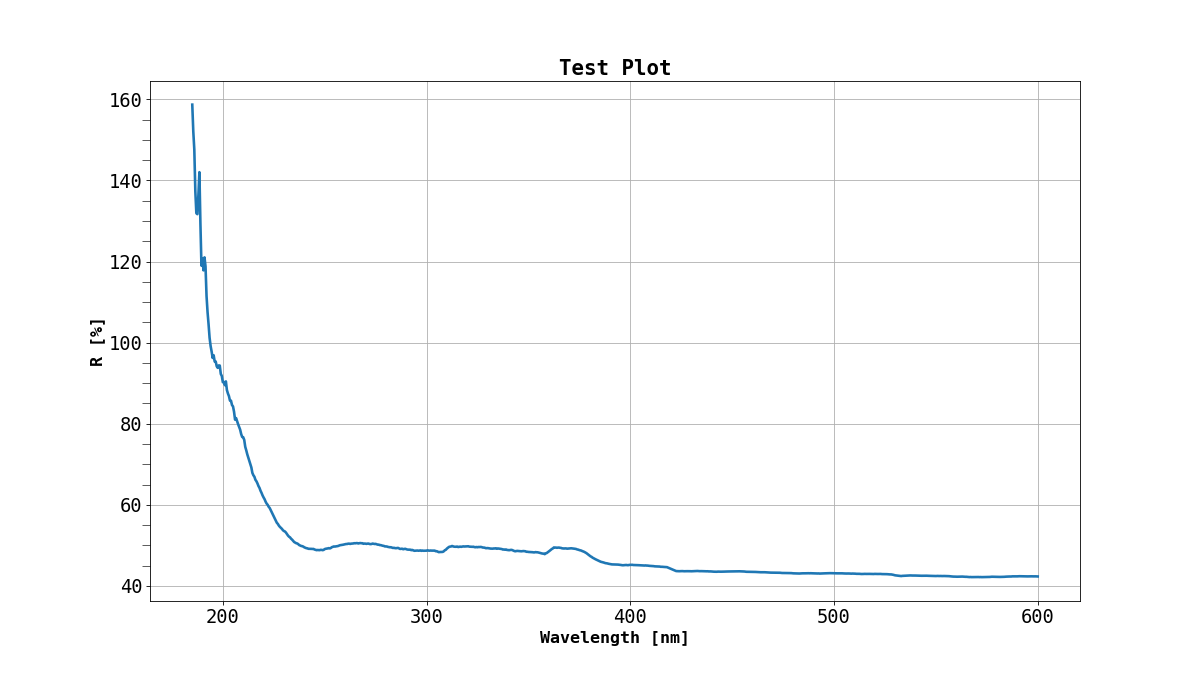

In [9]:
## ----------------------------------------- data -----------------------------------------
test_filename = 'pen_argset_B_back_corner4_gentlePress.txt'
test_data = pd.read_csv(path.join(data_dir, test_filename), delimiter="\t", decimal=",", skiprows=[0,1], names=['wavelength', 'R'])
# test_data
## ----------------------------------------- test plot -----------------------------------------
plt.close(1)
fig1, ax1 = plt.subplots(num=1, figsize=[16,9])
ax1.plot(test_data['wavelength'], test_data['R'])
## plt.locator_params(axis='x', nbins=5)
ax1.set_title('Test Plot')
ax1.set_xlabel('Wavelength [nm]')
ax1.set_ylabel('R [%]')
# ax1.set_ylim(2.9, 3.7)
ax1.grid()
# ax1.legend(loc='upper left')
# fig1.savefig(path.join(output_dir, 'plots','test_plot.png'))
# ax_inset = inset_axes(ax1, width="45%", height="45%", loc='center',
#                         bbox_to_anchor=(-0.10, -0.05, 1, 1), 
#                         bbox_transform=ax1.transAxes);
# ax_inset.plot(test_data['wavelength'], test_data['R'], color='red')
# ax_inset.set_ylim(90, 120)
# ax_inset.set_xlim(185, 230)
# ax_inset.grid()

## ----------------------------------------- Scatter and Error plots -----------------------------------------
# fig1, ax1 = plt.subplots()

# # ax1.scatter(tau3_file['index'], tau3_file['ch0']/1000, s=128, alpha=0.5, label='0', color='C0')
# # ax1.scatter(tau3_file['index'], tau3_file['ch1']/1000, s=128, alpha=0.5, label='1', color='C1')
# # ax1.scatter(tau3_file['index'], tau3_file['ch2']/1000, s=128, alpha=0.5, label='2', color='C2')

# ax1.errorbar(tau3_file['index'], tau3_file['ch0']/1000, \
#             yerr = np.sqrt(tau3_file['ch0_chisqr'])*tau3_file['ch0_sigma']/1000, fmt='o', elinewidth=1.0, \
#             linestyle='none', ecolor='C0', label='0') #'#ADFF2F'
# ax1.errorbar(tau3_file['index'], tau3_file['ch1']/1000, \
#             yerr = np.sqrt(tau3_file['ch1_chisqr'])*tau3_file['ch1_sigma']/1000, fmt='o', elinewidth=1.0, \
#             linestyle='none', ecolor='C1', label='1') #'#ADFF2F'
# ax1.errorbar(tau3_file['index'], tau3_file['ch2']/1000, \
#             yerr = np.sqrt(tau3_file['ch2_chisqr'])*tau3_file['ch2_sigma']/1000, fmt='o', elinewidth=1.0, \
#             linestyle='none', ecolor='C2', label='2') #'#ADFF2F'

# ## plt.locator_params(axis='x', nbins=5)
# ax1.set_xticks([1.0, 2.0, 3.0, 4.0, 5.0])
# ax1.set_xlabel('Run part')
# ax1.set_xticklabels(['$1^{st}$','$2^{nd}$','$3^{rd}$','$4^{th}$','$5^{th}$'])
# ax1.set_ylabel('Triplet lifetime [$\\mu$s]')
# ax1.set_ylim(2.9, 3.7)
# ax1.grid()
# ax1.legend(loc='upper left')
# fig1.savefig(path.join(output_dir, 'plots','tau3_PEN.png'))

In [10]:
23/15.2

1.5131578947368423

<h2 style='color:lightgreen; text-align:center'> Multiple samples full range</h2>

In [11]:
# pen_teonex_Q51_old_*.txt
# pen_teonex_Q51_*.txt
# PEN_Q51_50um_argset_*.txt
# PEN_Q53_UZH_*.txt
# no_sample_attempt2.txt
# reference_BaSO4_test_2.txt

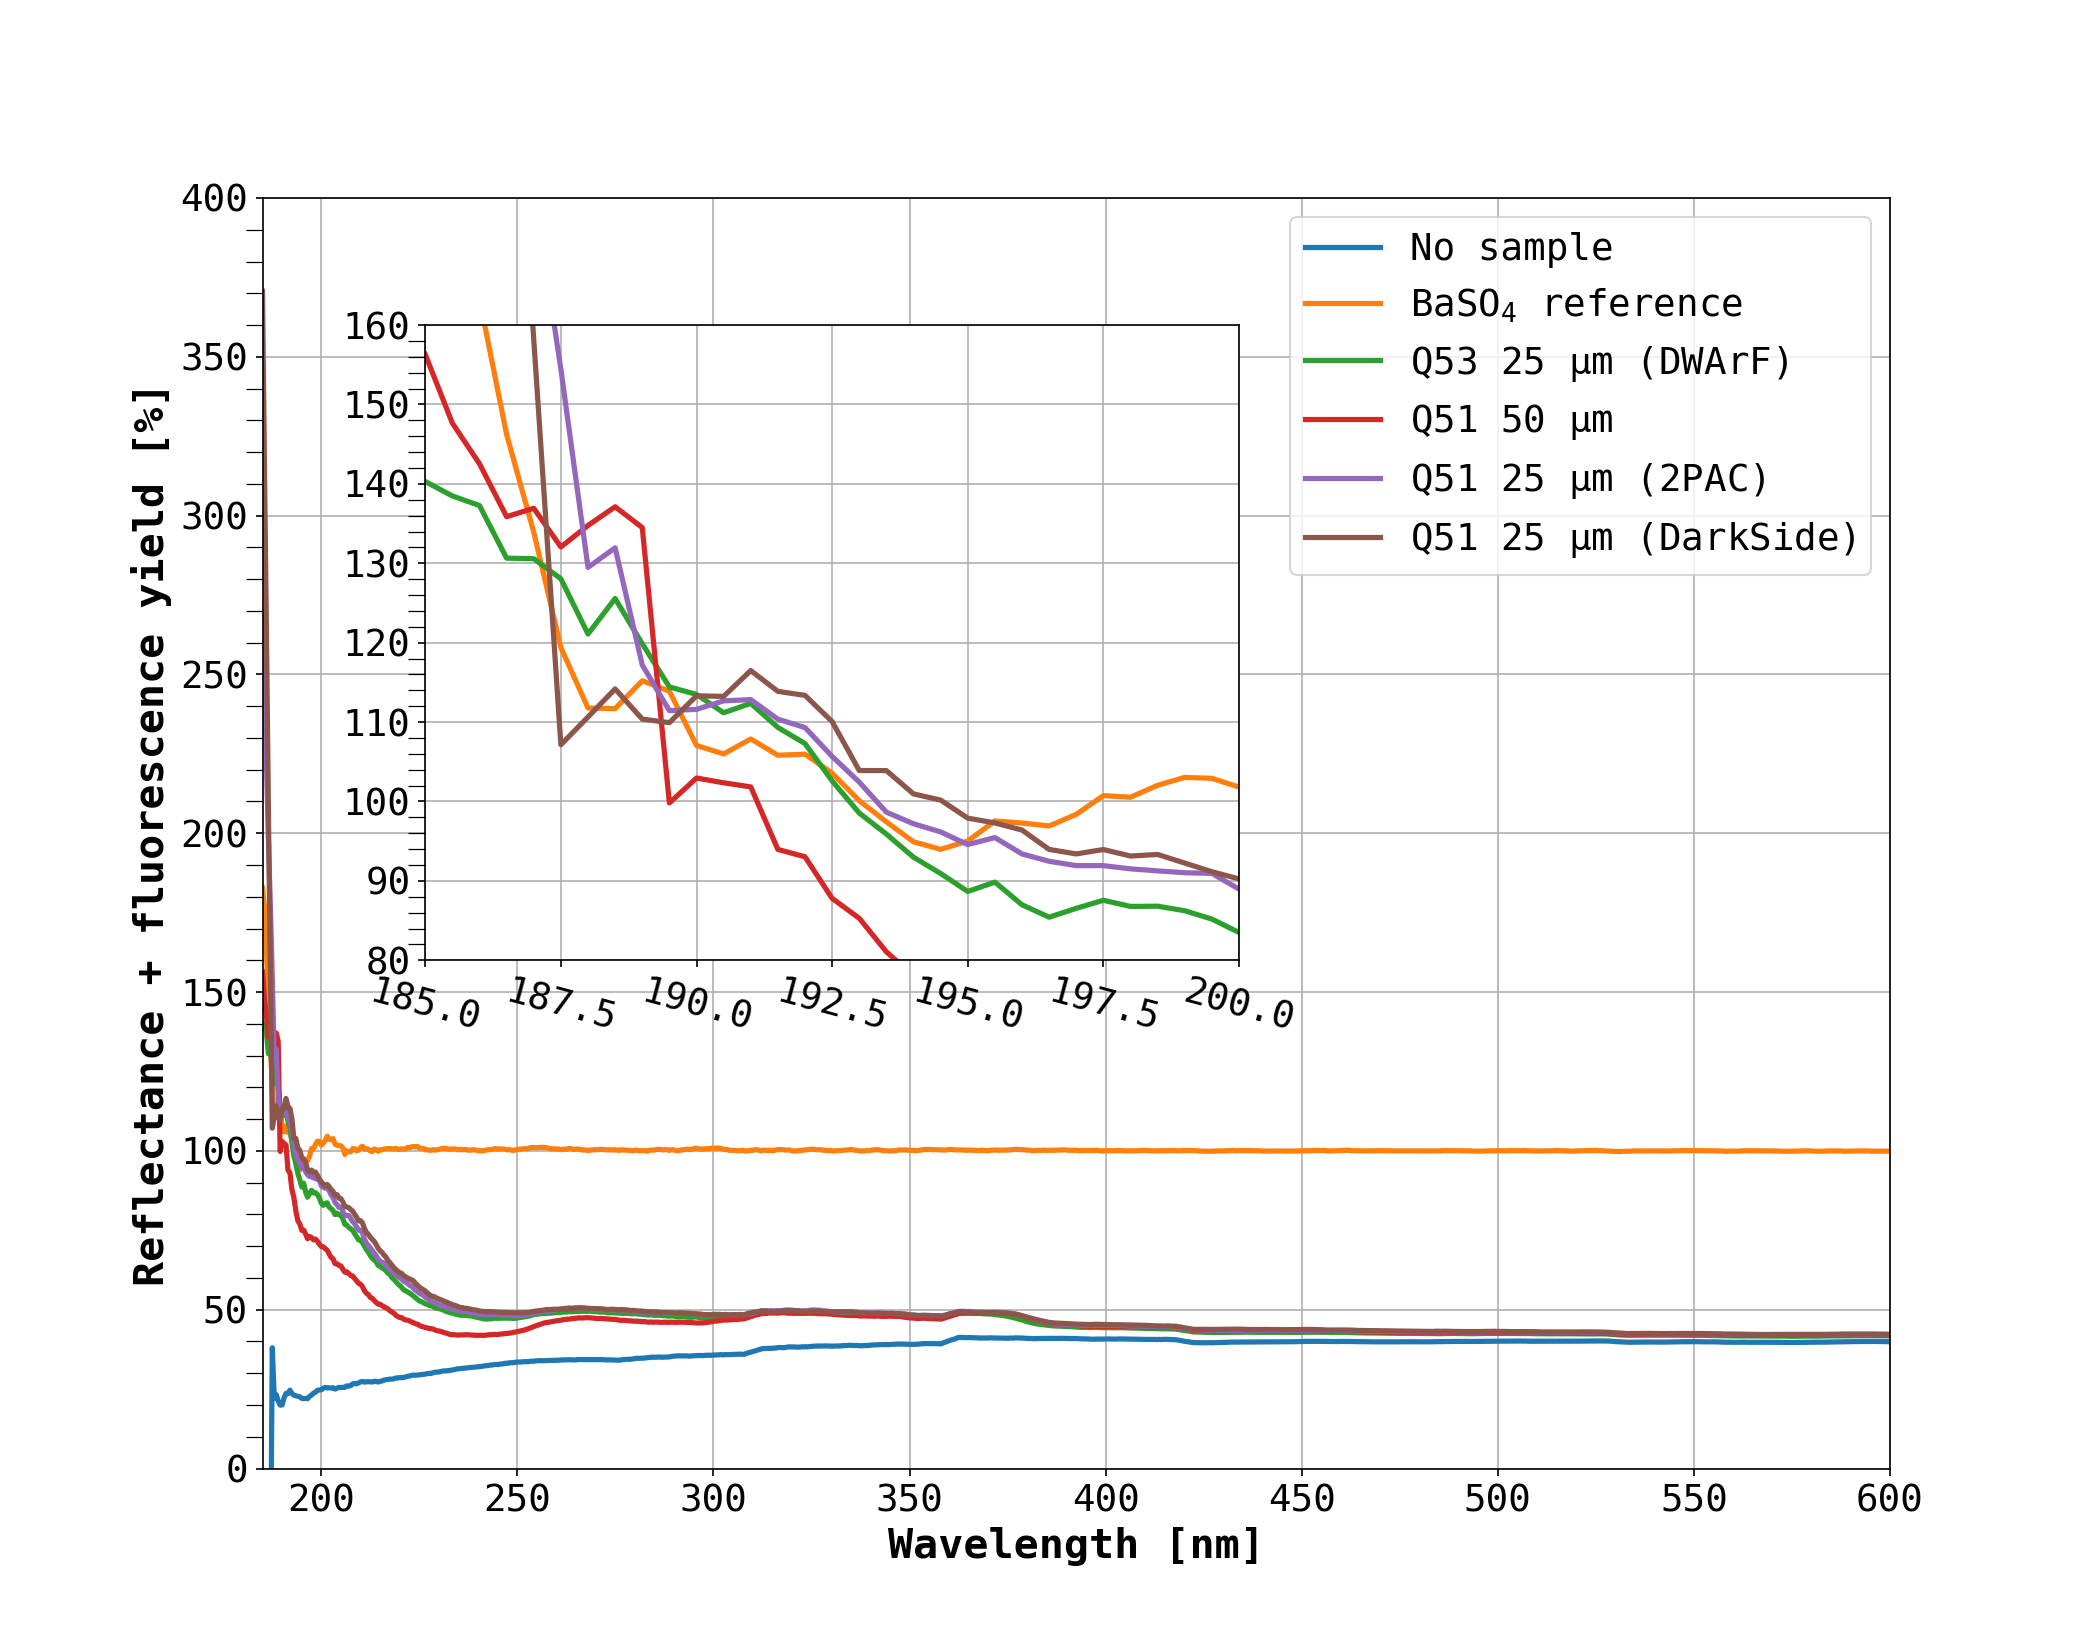

In [12]:
# plt.close(fig2)
## add_line(fig2, ax2, test_data)
# del fig2, ax2, ax_inset2
fig2, ax2, ax_inset2 = create_fig_with_inset(2)

data_filename_ls = ['no_sample_attempt2.txt', 'reference_BaSO4_test_2.txt', 'PEN_Q53_UZH_spot2.txt', 'PEN_Q51_50um_argset_commissioning_22042024_attempt2.txt', 'pen_teonex_Q51_old_spot3.txt', 'pen_argset_A_centre_front.txt']
wls_label_ls = ['No sample', 'BaSO$_{4}$ reference', 'Q53 25 $\\mu$m (DWArF)', 'Q51 50 $\\mu$m', 'Q51 25 $\\mu$m (2PAC)', 'Q51 25 $\\mu$m (DarkSide)']

# for index_d, datafile_path in enumerate(datafile_path_ls):
for index_d, data_filename in enumerate(data_filename_ls):
    # datafile = pd.read_csv(path.join(data_dir, datafile_path), delimiter="\t", decimal=",", skiprows=[0,1], names=['wavelength', 'R'])
    datafile = pd.read_csv(path.join(data_dir, data_filename), delimiter="\t", decimal=",", skiprows=[0,1], names=['wavelength', 'R'])
    add_line(fig2, ax2, ax_inset2, datafile, wls_label_ls[index_d], colorstr=f'C{index_d}')

In [13]:
# fig2.savefig('../reflectance_all_samples.png')

In [14]:
# plt.close(fig2)
# fig2

In [15]:
# stop

<h2 style='color:lightgreen; text-align:center'> Scatterplot: DS-20k and 2PAC </h2>

<!-- <p> -->
<span style='color:blue'>Consistency of DarkSide-20k veto PEN with pre-production samples (2PAC)</span> <br>

- scatter plot - x axis sample type (2PAC, DS A, B, C), y axis: \%R at 190 nm 
- histogram for all DS values (a, b, c) at 190 nm, fit a gauss to it - show chi2.ndf, mean with uncertainty, sigma with uncertainty
- table with for each sample type (2pac, a, b, c, a+b+c jointly) : mean, standard deviation (sigma), and Standard Error of the Mean (standard deviation / sqrt (number of samples) or from the fit )
<!-- </p> -->

Text(0, 0.5, 'Reflectance + fluorescence yield at 190 nm [%]')

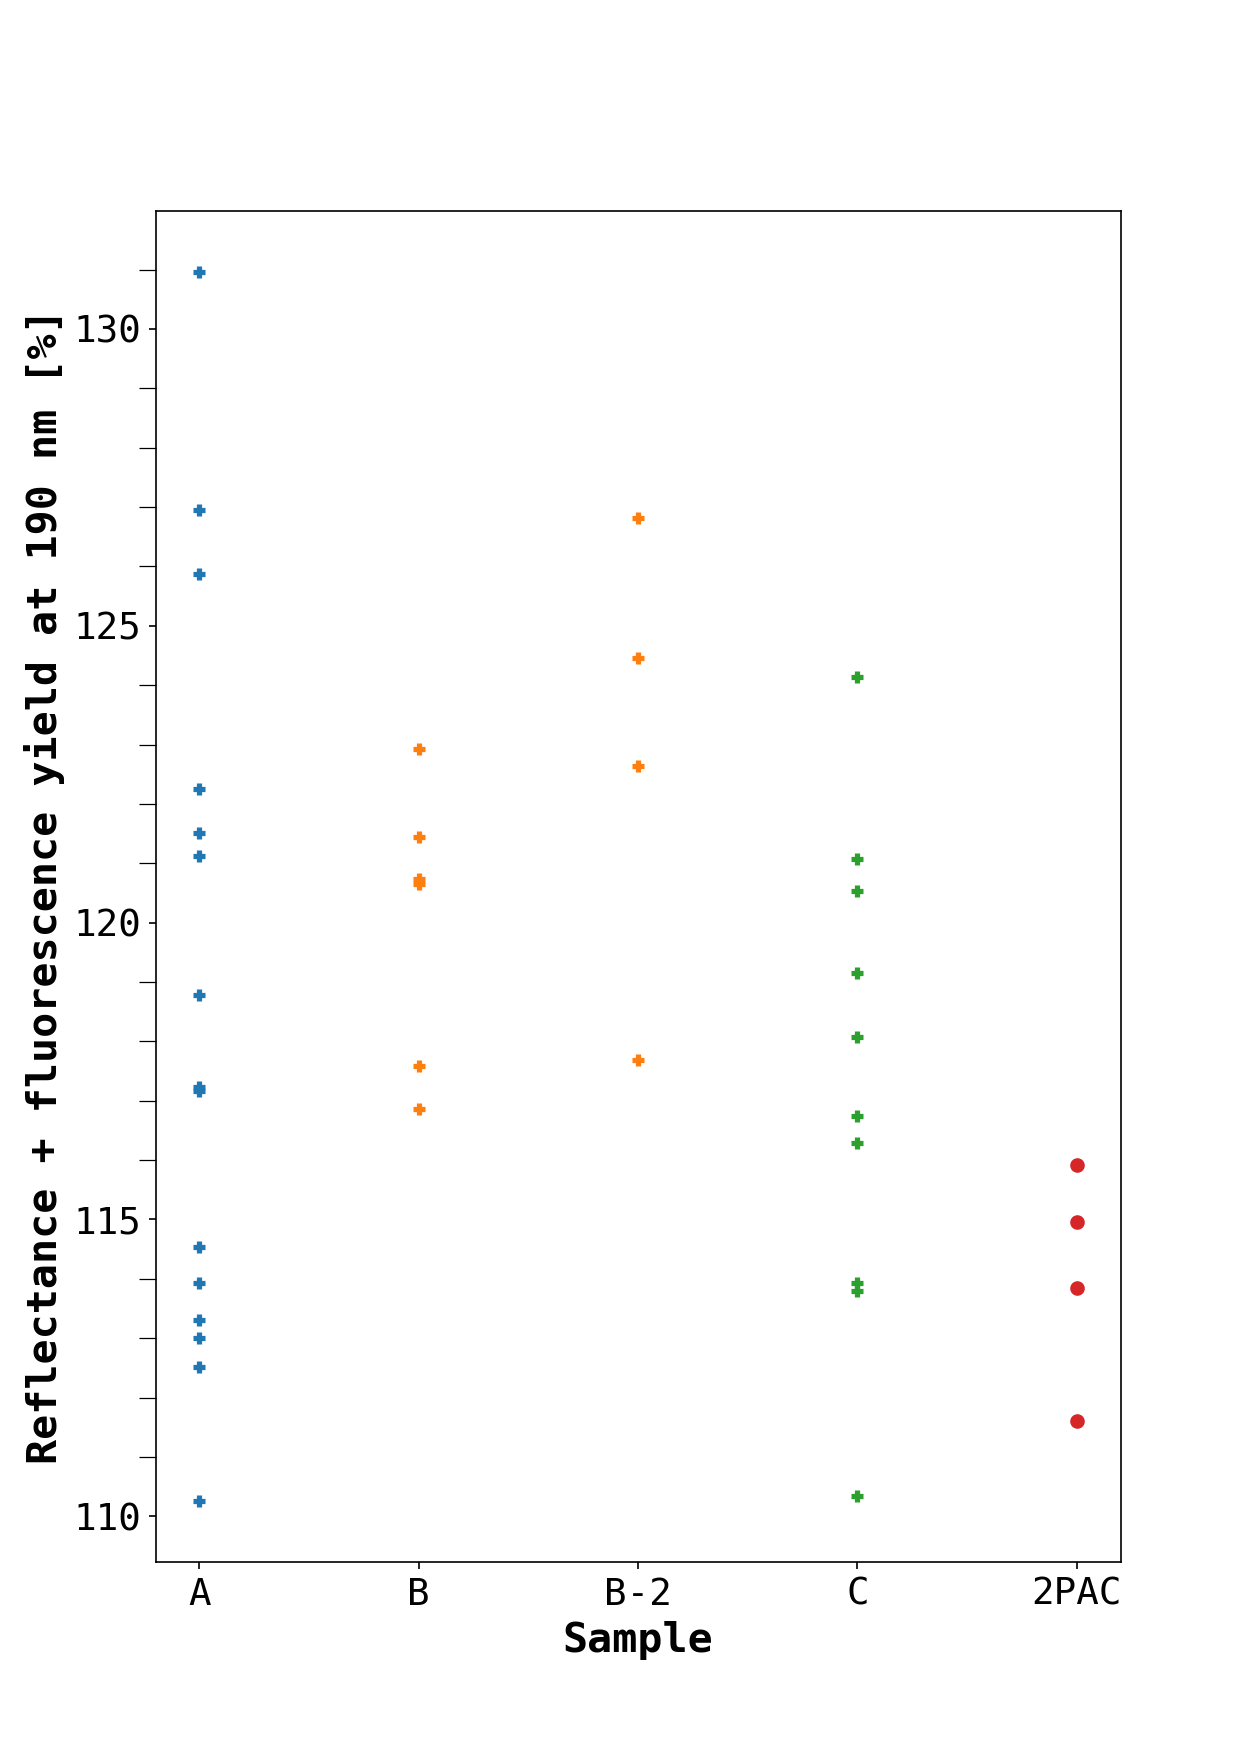

In [16]:
# del fig3, ax3, ax_inset3
# fig3, ax3= plt.subplots(2, 1, figsize=[14, 11], dpi=75);
# fig3, ax3= plt.subplots(1, 1, figsize=[14, 11], dpi=75);
fig3, ax3= plt.subplots(1, 1, figsize=(8.3, 11.7), dpi=150);

# R190_ls = []
filename_pattern = 'pen_argset_*.txt'
datafile_path_ls = glob(path.join(data_dir, filename_pattern))

# for index_d, datafile_path in enumerate(datafile_path_ls):
#     datafile = pd.read_csv(datafile_path, delimiter="\t", decimal=",", skiprows=[0,1], names=['wavelength', 'R'])
#     ax3[0].scatter(index_d, (datafile['R'][datafile['wavelength']==190]), marker='+', label='DarkSide-20k roll')

# filename_pattern = 'pen_teonex_Q51_old_*.txt'
# datafile_path_ls = glob(path.join(data_dir, filename_pattern))

# for index_e, datafile_path in enumerate(datafile_path_ls):
#     datafile = pd.read_csv(datafile_path, delimiter="\t", decimal=",", skiprows=[0,1], names=['wavelength', 'R'])
#     ax3[0].scatter(index_d + index_e+1, (datafile['R'][datafile['wavelength']==190]), marker='o', label='Old')

# ax3[0].set_xlabel('index', fontsize=20)
# ax3[0].set_ylabel('Reflection + Fluorescence at 190 nm[%]', fontsize=20)
# # ax3[0].legend()
filename_pattern_ls = ['pen_argset_A*.txt', 'pen_argset_B*.txt', 'pen_argset_otherB_*.txt', 'pen_argset_C*.txt', 'pen_teonex_Q51_old_*.txt']
# cntr = 0
colour_ls = ['C0', 'C1', 'C1', 'C2', 'C3']
marker_ls = ['+', '+', '+', '+','o']
label_ls = ['A', 'B', 'B-2', 'C', '2PAC']

for index_file, filename_pattern in enumerate(filename_pattern_ls):
    PEN_R190_ls = []
    datafile_path_ls = glob(path.join(data_dir, filename_pattern))
    for index_d, datafile_path in enumerate(datafile_path_ls):
        datafile = pd.read_csv(datafile_path, delimiter="\t", decimal=",", skiprows=[0,1], names=['wavelength', 'R'])
        PEN_R190_ls.append(datafile['R'][datafile['wavelength']==190])
        # ax3[1].scatter(cntr, (datafile['R'][datafile['wavelength']==190]), marker=marker_ls[index_file], color=colour_ls[index_file])
        ax3.scatter(label_ls[index_file], (datafile['R'][datafile['wavelength']==190].iloc[0]), marker=marker_ls[index_file], color=colour_ls[index_file])
        # cntr += 1
    # ax3[1].scatter(np.arange(len(PEN_R190_ls))+ index_file+1, PEN_R190_ls, marker=marker_ls[index_file], color=colour_ls[index_file], label=filename_pattern.split(sep='*')[0])
# ax3[1].legend()
ax3.set_xlabel('Sample', fontsize=20)
ax3.set_ylabel('Reflectance + fluorescence yield at 190 nm [%]', fontsize=20)

In [17]:
# fig3.savefig('../scatter_reflectance_at_190nm.png')

In [18]:
# stop

<h2 style='color:lightgreen; text-align:center'> Histogram: DS-20k and 2PAC </h2>

<h3> Resource: Log-Likelihood </h3>
<a href='https://medium.com/towards-data-science/probability-concepts-explained-maximum-likelihood-estimation-c7b4342fdbb1'>url</a>

In [19]:
filename_pattern_ls = ['pen_argset_A*.txt', 'pen_argset_B*.txt', 'pen_argset_otherB_*.txt', 'pen_argset_C*.txt']

PEN_R190_ls = []

for index_file, filename_pattern in enumerate(filename_pattern_ls):
    datafile_path_ls = glob(path.join(data_dir, filename_pattern))
    for index_d, datafile_path in enumerate(datafile_path_ls):
        datafile = pd.read_csv(datafile_path, delimiter="\t", decimal=",", skiprows=[0,1], names=['wavelength', 'R'])
        PEN_R190_ls.append(datafile['R'][datafile['wavelength']==190].iloc[0])

Text(0, 0.5, 'counts')

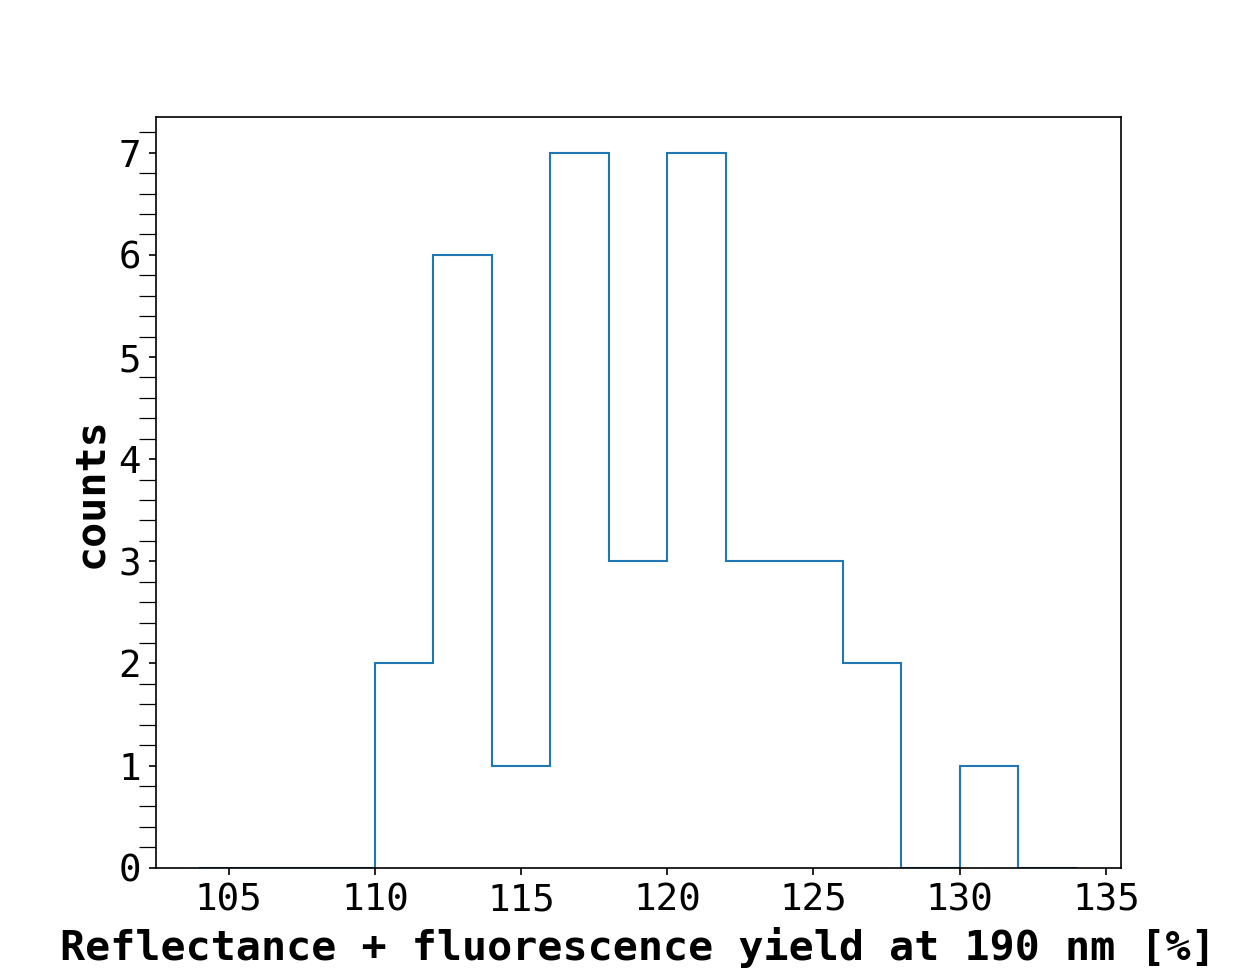

In [20]:
# fig4, ax4= plt.subplots(1, 1, figsize=[14, 11], dpi=75)
fig4, ax4= plt.subplots(1, 1, figsize=(8.3, 6.5), dpi=150) #11.7), dpi=150)

# hist_content, hist_edges, _histObjects = ax4.hist(PEN_R190_ls, bins=10, histtype='step', label='data')
hist_content, hist_edges, _histObjects = ax4.hist(PEN_R190_ls, bins=np.arange(104, 136, 2), histtype='step', label='data')
ax4.set_xlabel('Reflectance + fluorescence yield at 190 nm [%]', fontsize=20)
ax4.set_ylabel('counts', fontsize=20)

<h3> iMinuit chisquare fit </h3>

In [21]:
# from iminuit import Minuit
# # from iminuit.cost import LeastSquares
# # from iminuit.cost import BinnedNLL
# from iminuit.cost import ExtendedBinnedNLL

# cost_func = LeastSquares(hist_edges[:-1], hist_content, np.sqrt(hist_content), f_gauss)
# p0_input = [120, 4.9, 50]

# m2 = Minuit(cost_func, *p0_input)

# m2.limits["f_mean"] = (90, None)
# m2.limits["f_sigma"] = (0, 10)
# m2.limits["f_k"] = (None, 100)

In [22]:
# plt.subplots(figsize=[12,12], dpi=150)
# m2.migrad()

In [23]:
# m2.params['f_mean'].value

<h3>iminuit Binned log-likelihood fit</h3>

In [24]:
# # cost_func = np.sum(f_gauss(hist_edges[:-1], *p0_input) - hist_content) # custom_cost

# # cost_func = BinnedNLL(hist_content, hist_edges, f_gauss, verbose=0, use_pdf='numerical')

# from scipy.stats import norm
# def f_gauss_imi(x, mu, sigma):
#     return norm.pdf(x, mu, sigma)
# # def f_gauss_imi(x, mu, sigma, k):
# #     return k*norm.pdf(x, mu, sigma)

# cost_func = BinnedNLL(hist_content, hist_edges, f_gauss_imi, verbose=0, use_pdf='numerical')
# # cost_func = ExtendedBinnedNLL(hist_content, hist_edges, f_gauss_imi, verbose=0, use_pdf='numerical')
# # cost_func = ExtendedBinnedNLL(hist_content, hist_edges, f_gauss, verbose=0, use_pdf='numerical')

# p0_input = [120, 4.9]
# # p0_input = [120, 4.9, 50]

# m3 = Minuit(cost_func, *p0_input)

In [25]:
# # m3.limits["f_mean"] = (90, None)
# # m3.limits["f_sigma"] = (0, 10)
# # m3.limits["f_k"] = (None, 100)

# m3.limits["mu"] = (None, None)
# m3.limits["sigma"] = (None, None)
# # m3.limits["sigma"] = (0, 10)
# # m3.limits["k"] = (None, 100)

In [26]:
# m3.migrad()

<h3>iminuit Extended Binned log-likelihood</h3>

In [27]:
# # def compute_cdf(pmf):
# #     return
# from scipy.special import erf

In [28]:
# plt.close(10)
# plt.figure(10)
# a = np.arange(-3, 3, 0.100)
# plt.plot(a, erf(a))

In [29]:
# def cdf_gauss(x, f_mean, f_sigma, f_k):
#     return f_k*0.5*(1 + erf((x-f_mean)/(f_sigma*np.sqrt(2))))

In [30]:
# cost_func = np.sum(f_gauss(hist_edges[:-1], *p0_input) - hist_content) # custom_cost

# cost_func = BinnedNLL(hist_content, hist_edges, f_gauss, verbose=0, use_pdf='numerical')

# from scipy.stats import norm
# def f_gauss_imi(x, mu, sigma, k):
#     return k*norm.pdf(x, mu, sigma)

# cost_func = BinnedNLL(hist_content, hist_edges, f_gauss_imi, verbose=0, use_pdf='numerical')
# cost_func = ExtendedBinnedNLL(hist_content, hist_edges, f_gauss_imi, verbose=0, use_pdf='numerical')
cost_func = ExtendedBinnedNLL(hist_content, hist_edges, f_gauss, verbose=0, use_pdf='numerical')
# cost_func = ExtendedBinnedNLL(hist_content, hist_edges, cdf_gauss, verbose=0)

# p0_input = [120, 4.9]
p0_input = [120, 4.9, 50]
p0_input[2] = int(np.sum(hist_content))

m4 = Minuit(cost_func, *p0_input)
m4.limits["f_mean"] = (90, None)
m4.limits["f_sigma"] = (0, 10)
# m4.limits["f_k"] = (None, 100)
m4.fixed['f_k'] = True

# m4.limits["mu"] = (90, None)
# m4.limits["sigma"] = (0, 10)
# m4.limits["k"] = (None, 100)

In [31]:
m4.migrad();

In [32]:
m4.hesse()
# m4.interactive()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.47 (χ²/ndof = 1.1)      │              Nfcn = 47               │
│ EDM = 1.52e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ f_mean  │   119.1   │    0.9    │            │            │   90    │         │       │
│ 1 │ f_sigma │    4.9    │    0.6    │            │            │    0    │   10    │       │
│ 2 │ f_k     │   35.00   │   0.35    │            │            │         │         │  yes  │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬─────────────────────────┐
│         │  f_mean f_sigma     f_k │
├─────────┼─────────────────────────┤
│  f_mean │   0.724     0.0     0.0 │
│ f_sigma │     0.0   0.409     0.0 │
│     f_k │     0.0     0.0       0 │
└─────────┴─────────────────────────┘

In [33]:
# rng = np.random.default_rng(1)

x_samples = rng.normal(m4.values[0], m4.values[1], size=int(1e6)) #size=int(m4.values[2]))
x_hist_content, hist_edges = np.histogram(x_samples, bins=hist_edges);
hist_centres = hist_edges + 0.5*(hist_edges[1]-hist_edges[0])
ax4.plot(hist_centres[:-1], x_hist_content*m4.values[2]/np.sum(x_hist_content), color='red', label='fit')
# ax4.legend(loc='upper left')
red_chisqr_value = red_chisq(hist_content, \
    f_gauss(hist_centres[:-1], m4.values[0], m4.values[1], m4.values[2]/np.sum(x_hist_content)), np.array(m4.values)
    )
## Manualy read from m4
## TODO make it dynamic
red_chisqr_value = 1.1
fitted_parameter = np.array(m4.values)
text_in_box2 = AnchoredText(f"statistics = {int(np.sum(hist_content))}" '\np-value = 'f"{calc_pvalue(PEN_R190_ls, m4):.3f}" '\n$\mu$' f' = {fitted_parameter[0]:.3f}' '\n$\sigma$' f' = {fitted_parameter[1]:.3f}',\
                                        prop=dict(size=14), loc='center right', bbox_to_anchor=(1.0, 0.73), bbox_transform=ax4.transAxes)
text_in_box2.patch.set_alpha(0.1)
ax4.add_artist(text_in_box2)

ax4.legend(loc='upper right', fontsize=14)

Adjusted p-value: 0.25


/tmp/ipykernel_2948194/3856201222.py:19: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  p_value = anderson_ksamp([np.array(data_ls), simulated_data]).significance_level;


In [34]:
calc_pvalue(PEN_R190_ls, m4)

Adjusted p-value: 0.25


/tmp/ipykernel_2948194/3856201222.py:19: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  p_value = anderson_ksamp([np.array(data_ls), simulated_data]).significance_level;


0.25

In [35]:
# fig4.savefig("../reflectance_DS_all_samples.png")

In [36]:
# stop

<h2 style='color:lightgreen; text-align:center'> Histogram: DS-20k Front and Back </h2>

In [37]:
filename_pattern_ls = ['*Bottom*.txt']
PEN_R190_Bottom_ls = []
PEN_R190_Top_ls = []

for index_file, filename_pattern in enumerate(filename_pattern_ls):
    datafile_path_ls = glob(path.join(data_dir, filename_pattern))
    for index_d, datafile_path in enumerate(datafile_path_ls):
        # print(f"{index_d}, {datafile_path.split(sep='/')[-1]}")
        datafile = pd.read_csv(datafile_path, delimiter="\t", decimal=",", skiprows=[0,1], names=['wavelength', 'R'])
        PEN_R190_Bottom_ls.append(datafile['R'][datafile['wavelength']==190].iloc[0])

filename_pattern_ls = ['*Top*.txt']
for index_file, filename_pattern in enumerate(filename_pattern_ls):
    datafile_path_ls = glob(path.join(data_dir, filename_pattern))
    for index_d, datafile_path in enumerate(datafile_path_ls):
        # print(f"{index_d}, {datafile_path.split(sep='/')[-1]}")
        datafile = pd.read_csv(datafile_path, delimiter="\t", decimal=",", skiprows=[0,1], names=['wavelength', 'R'])
        PEN_R190_Top_ls.append(datafile['R'][datafile['wavelength']==190].iloc[0])

In [38]:
sorted(PEN_R190_Bottom_ls)

[116.2878,
 116.7502,
 118.0805,
 120.5388,
 121.0772,
 121.125,
 121.5093,
 126.944,
 130.9586]

Text(0.5, 1.0, 'Bottom: A and C')

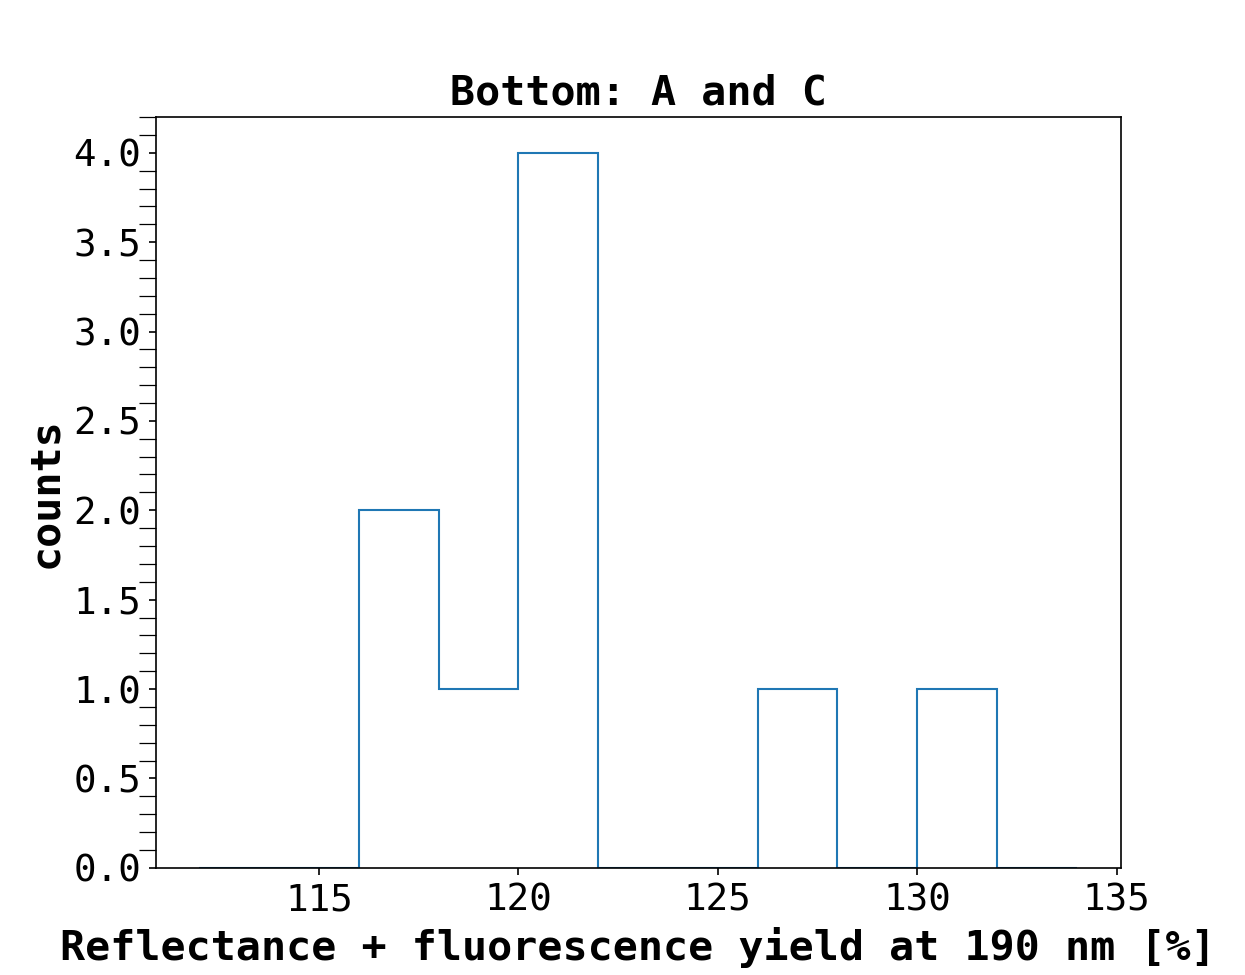

In [39]:
fig5, ax5= plt.subplots(1, 1, figsize=[8.3, 6.5], dpi=150)#[14, 11], dpi=75)

# hist_content, hist_edges, _histObjects = ax5.hist(PEN_R190_Bottom_ls, bins=5, histtype='step')
# hist_content, hist_edges, _histObjects = ax5.hist(PEN_R190_Bottom_ls, bins=np.arange(112, 134, 2), histtype='step')
# hist_content, hist_edges, _histObjects = ax5.hist(PEN_R190_Bottom_ls, bins=np.arange(113, 135, 2), histtype='step', label='data')
# hist_content, hist_edges, _histObjects = ax5.hist(PEN_R190_Bottom_ls, bins=np.arange(111, 135, 2), histtype='step', label='data')
hist_content, hist_edges, _histObjects = ax5.hist(PEN_R190_Bottom_ls, bins=np.arange(112, 136, 2), histtype='step', label='data')
ax5.set_xlabel('Reflectance + fluorescence yield at 190 nm [%]', fontsize=20)
ax5.set_ylabel('counts', fontsize=20)
ax5.set_title('Bottom: A and C')

In [40]:
hist_edges

array([       112,        114,        116,        118,        120,
              122,        124,        126,        128,        130,
              132,        134])

In [41]:
cost_func = ExtendedBinnedNLL(hist_content, hist_edges, f_gauss, verbose=0, use_pdf='numerical')
# cost_func = ExtendedBinnedNLL(hist_content, hist_edges, cdf_gauss, verbose=0)

# p0_input = [120, 4.9]
p0_input = [120, 4.9, 9]
p0_input[2] = int(np.sum(hist_content))

m5 = Minuit(cost_func, *p0_input)
m5.limits["f_mean"] = (90, None)
m5.limits["f_sigma"] = (0, None)
# m5.limits["f_k"] = (None, 10)
m5.fixed["f_k"] = True

In [42]:
m5.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 13.41 (χ²/ndof = 1.5)      │              Nfcn = 46               │
│ EDM = 3.33e-07 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ f_mean  │   121.5   │    1.7    │            │            │   90    │         │       │
│ 1 │ f_sigma │    4.6    │    1.4    │            │            │    0    │         │       │
│ 2 │ f_k     │   9.00    │   0.09    │            │            │         │         │  yes  │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬─────────────────────────┐
│         │  f_mean f_sigma     f_k │
├─────────┼─────────────────────────┤
│  f_mean │    2.79    -0.4     0.0 │
│ f_sigma │    -0.4    1.98       0 │
│     f_k │     0.0       0       0 │
└─────────┴─────────────────────────┘

In [43]:
m5.hesse();

In [44]:
# rng = np.random.default_rng(1)

x_samples = rng.normal(m5.values[0], m5.values[1], size=int(1e6))
x_hist_content, hist_edges = np.histogram(x_samples, bins=hist_edges);
hist_centres = hist_edges + 0.5*(hist_edges[1]-hist_edges[0])
ax5.plot(hist_centres[:-1], x_hist_content*m5.values[2]/np.sum(x_hist_content), color='red', label='fit')
# ax5.plot(hist_centres[:-1], hist_content*m5.values[2]/np.sum(hist_content), color='red', label='fit')
# ax5.legend(loc='upper left')
## Read from m5
## TODO make it dynamic
# red_chisqr_value = 1.7
fitted_parameter = np.array(m5.values)
text_in_box2 = AnchoredText(f"statistics = {int(np.sum(hist_content))}" '\np-value = 'f"{calc_pvalue(PEN_R190_Bottom_ls, m5):.3f}" '\n$\mu$' f' = {fitted_parameter[0]:.3f}' '\n$\sigma$' f' = {fitted_parameter[1]:.3f}',\
                                        prop=dict(size=14), loc='center right', bbox_to_anchor=(1.0, 0.65), bbox_transform=ax4.transAxes)
text_in_box2.patch.set_alpha(0.1)
ax5.add_artist(text_in_box2)
ax5.legend(loc='upper right', fontsize=14)#20)

Adjusted p-value: 0.07


In [45]:
# text_in_box = AnchoredText(f"statistics = {int(np.sum(hist_content))}" '\n$\mu$' f' = {np.mean(PEN_R190_Bottom_ls):.3f}' '\n$\sigma$' f' = {np.std(PEN_R190_Bottom_ls):.3f}', 
#                         #    '\n$\\chi^{2}/\\nu$' f" = {red_chisqr_value:.2f}" '\n$\mu$' f' = {fitted_parameters[0]:.3f}' '\n$\sigma$' f' = {fitted_parameters[1]:.3f}',\
#                                         prop=dict(size=18), loc='upper right')
# ax5.add_artist(text_in_box)

In [46]:
# fig5.savefig("../reflectance_DS_BottomSurface.png")

In [47]:
calc_pvalue(PEN_R190_Bottom_ls, m5)

Adjusted p-value: 0.25


/tmp/ipykernel_2948194/3856201222.py:19: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  p_value = anderson_ksamp([np.array(data_ls), simulated_data]).significance_level;


0.25

In [48]:
# stop

<p>###########################################################################################################################</p>

Text(0.5, 1.0, 'TopSurface: A and C')

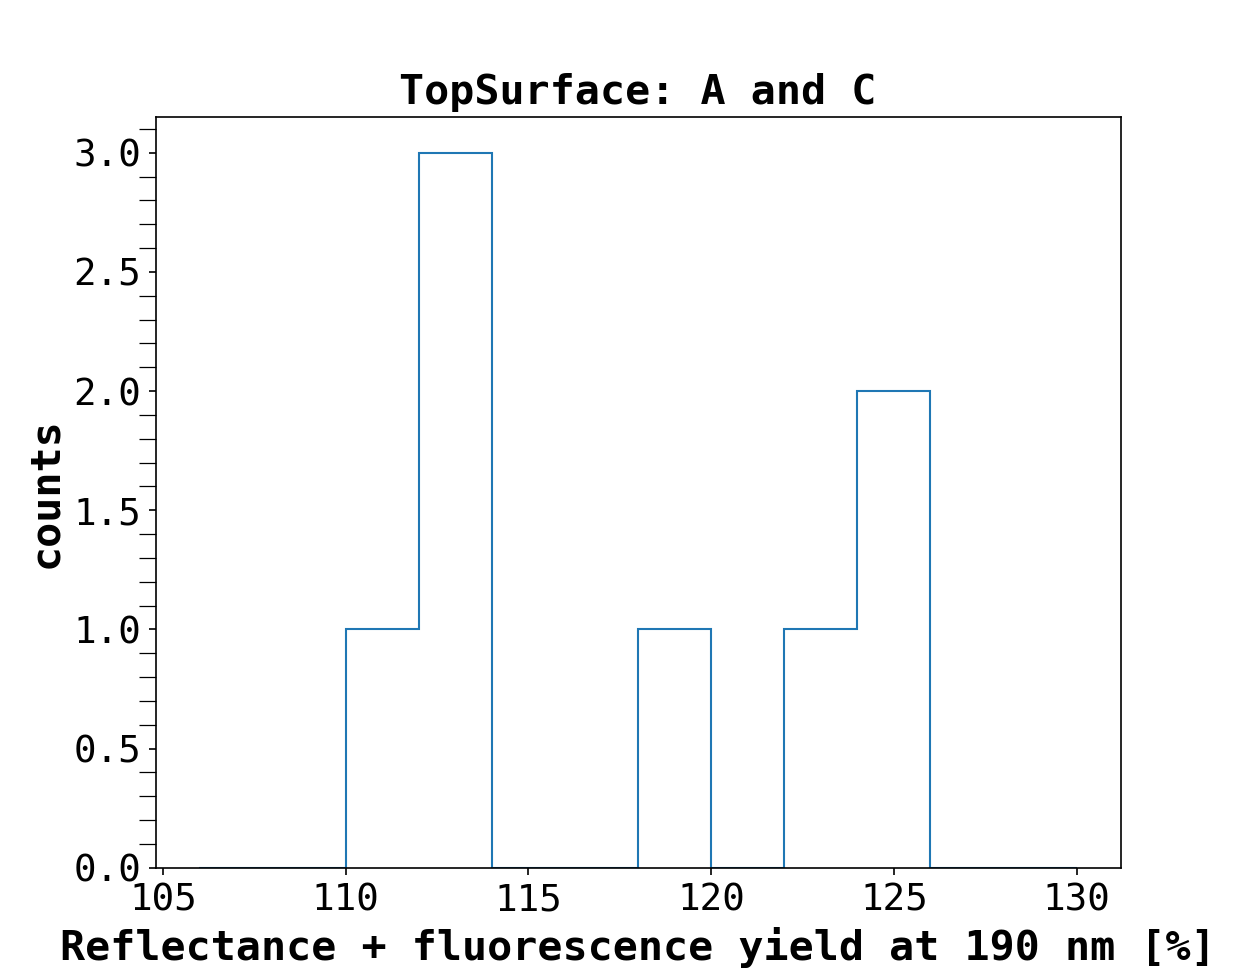

In [49]:
fig6, ax6= plt.subplots(1, 1, figsize=[8.3, 6.5], dpi=150)#[14, 11], dpi=75)

# hist_content, hist_edges, _histObjects = ax6.hist(PEN_R190_Edges_ls, bins=5, histtype='step')
hist_content, hist_edges, _histObjects = ax6.hist(PEN_R190_Top_ls, bins=np.arange(106, 132, 2), histtype='step', label='data')
ax6.set_xlabel('Reflectance + fluorescence yield at 190 nm [%]', fontsize=20)
ax6.set_ylabel('counts', fontsize=20)
ax6.set_title('TopSurface: A and C')

In [50]:
sorted(PEN_R190_Top_ls)

[110.3364, 113.0085, 113.7941, 113.9235, 119.1593, 122.246, 124.1298, 125.8703]

In [51]:
hist_edges

array([       106,        108,        110,        112,        114,
              116,        118,        120,        122,        124,
              126,        128,        130])

In [52]:
text_in_box = AnchoredText(f"statistics = {int(np.sum(hist_content))}" '\n$\mu$' f' = {np.mean(PEN_R190_Top_ls):.3f}' '\n$\sigma$' f' = {np.std(PEN_R190_Top_ls):.3f}', 
                        #    '\n$\\chi^{2}/\\nu$' f" = {red_chisqr_value:.2f}" '\n$\mu$' f' = {fitted_parameters[0]:.3f}' '\n$\sigma$' f' = {fitted_parameters[1]:.3f}',\
                                        prop=dict(size=18), loc='upper center')
# ax6.add_artist(text_in_box)

In [53]:
cost_func = ExtendedBinnedNLL(hist_content, hist_edges, f_gauss, verbose=0, use_pdf='numerical')
# cost_func = ExtendedBinnedNLL(hist_content, hist_edges, cdf_gauss, verbose=0)

# p0_input = [120, 4.9]
p0_input = [120, 4.9, 8]
p0_input[2] = int(np.sum(hist_content))

m6 = Minuit(cost_func, *p0_input)
m6.limits["f_mean"] = (90, None)
m6.limits["f_sigma"] = (0, None)
# m6.limits["f_k"] = (None, 10)
m6.fixed["f_k"] = True

In [54]:
m6.migrad();

In [55]:
m6.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 14.49 (χ²/ndof = 1.4)      │              Nfcn = 45               │
│ EDM = 3.75e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ f_mean  │   117.7   │    2.7    │            │            │   90    │         │       │
│ 1 │ f_sigma │    6.5    │    2.5    │            │            │    0    │         │       │
│ 2 │ f_k     │   8.00    │   0.08    │            │            │         │         │  yes  │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬─────────────────────────┐
│         │  f_mean f_sigma     f_k │
├─────────┼─────────────────────────┤
│  f_mean │    7.19      -0       0 │
│ f_sigma │      -0    6.46       0 │
│     f_k │       0       0       0 │
└─────────┴─────────────────────────┘

In [56]:
# rng = np.random.default_rng(1)

x_samples = rng.normal(m6.values[0], m6.values[1], size=int(1e6))
x_hist_content, hist_edges = np.histogram(x_samples, bins=hist_edges);
hist_centres = hist_edges + 0.5*(hist_edges[1]-hist_edges[0])
ax6.plot(hist_centres[:-1], x_hist_content*m6.values[2]/np.sum(x_hist_content), color='red', label='fit')
# ax6.plot(hist_centres[:-1], hist_content*m6.values[2]/np.sum(hist_content), color='red', label='fit')
# ax6.legend(loc='upper left')
## Manually read from m6
## TODO make it dynamic
# red_chisqr_value = 1.4
fitted_parameter = np.array(m6.values)
text_in_box2 = AnchoredText(f"statistics = {int(np.sum(hist_content))}" '\np-value = 'f"{calc_pvalue(PEN_R190_Top_ls, m6):.3f}"'\n$\mu$' f' = {fitted_parameter[0]:.3f}' '\n$\sigma$' f' = {fitted_parameter[1]:.3f}',\
                                        prop=dict(size=14), loc='center right', bbox_to_anchor=(0.75, 0.875), bbox_transform=ax6.transAxes)
text_in_box2.patch.set_alpha(0.1)
ax6.add_artist(text_in_box2)
ax6.legend(loc='upper right', fontsize=14)#20)

Adjusted p-value: 0.21


In [57]:
# fig6.savefig("../reflectance_DS_TopSurface.png")

In [58]:
calc_pvalue(PEN_R190_Top_ls, m6)

Adjusted p-value: 0.25


/tmp/ipykernel_2948194/3856201222.py:19: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  p_value = anderson_ksamp([np.array(data_ls), simulated_data]).significance_level;


0.25

In [59]:
# stop

<p>###########################################################################################################################</p>

<h2 style='color:lightgreen; text-align:center'> Histogram: DS-20k Centre and Edges </h2>

In [60]:
filename_pattern_ls = ['*_B_*.txt']
PEN_R190_Centre_ls = []
PEN_R190_Edges_ls = []

for index_file, filename_pattern in enumerate(filename_pattern_ls):
    datafile_path_ls = glob(path.join(data_dir, filename_pattern))
    for index_d, datafile_path in enumerate(datafile_path_ls):
        # print(f"{index_d}, {datafile_path.split(sep='/')[-1]}")
        datafile = pd.read_csv(datafile_path, delimiter="\t", decimal=",", skiprows=[0,1], names=['wavelength', 'R'])
        PEN_R190_Centre_ls.append(datafile['R'][datafile['wavelength']==190].iloc[0])

filename_pattern_ls = ['*_A_*.txt', '*_C_*.txt']
for index_file, filename_pattern in enumerate(filename_pattern_ls):
    datafile_path_ls = glob(path.join(data_dir, filename_pattern))
    for index_d, datafile_path in enumerate(datafile_path_ls):
        # print(f"{index_d}, {datafile_path.split(sep='/')[-1]}")
        datafile = pd.read_csv(datafile_path, delimiter="\t", decimal=",", skiprows=[0,1], names=['wavelength', 'R'])
        PEN_R190_Edges_ls.append(datafile['R'][datafile['wavelength']==190].iloc[0])

<p>###########################################################################################################################</p>

array([       112,        114,        116,        118,        120,
              122,        124,        126,        128])

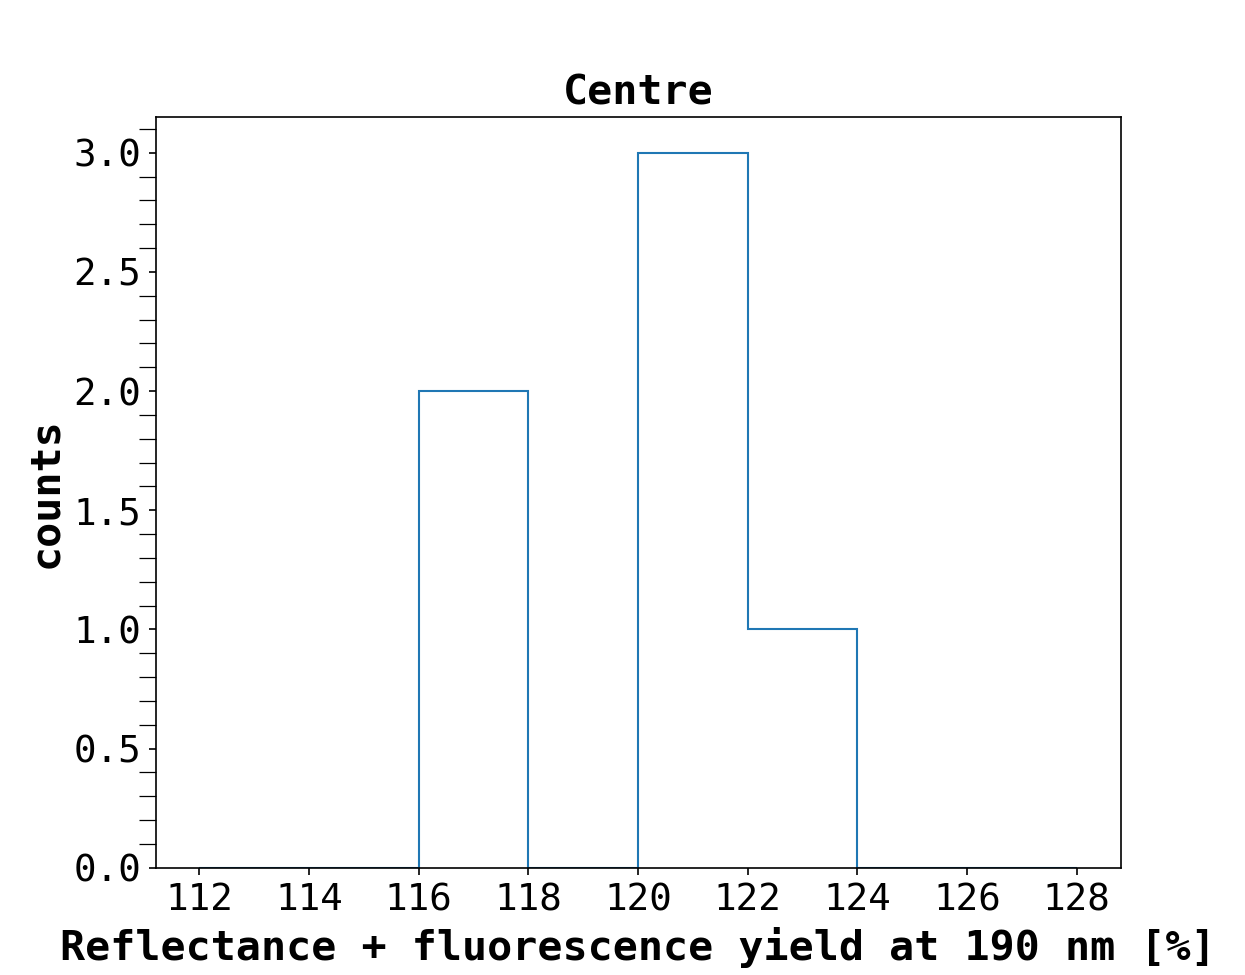

In [61]:
fig7, ax7= plt.subplots(1, 1, figsize=[8.3, 6.5], dpi=150) #[14, 11], dpi=75)

hist_content, hist_edges, _histObjects = ax7.hist(PEN_R190_Centre_ls, bins=np.arange(112, 130, 2), histtype='step', label='data')
# # hist_content, hist_edges, _histObjects = ax7.hist(PEN_R190_Centre_ls, bins=np.arange(110, 132, 2), histtype='step')
# # hist_content, hist_edges, _histObjects = ax7.hist(PEN_R190_Centre_ls, bins=np.arange(112, 130, 1), histtype='step')
# # hist_content, hist_edges, _histObjects = ax7.hist(PEN_R190_Centre_ls, bins=np.arange(111, 129, 2), histtype='step')
# # hist_content, hist_edges, _histObjects = ax7.hist(PEN_R190_Centre_ls, bins=np.arange(111, 129, 1), histtype='step')
ax7.set_xlabel('Reflectance + fluorescence yield at 190 nm [%]', fontsize=20)
# ax7.tick_params(axis='x', rotation=-15)
ax7.set_xticks(np.arange(112, 130, 2))
ax7.set_ylabel('counts', fontsize=20)
ax7.set_title('Centre')
hist_edges

In [62]:
# text_in_box = AnchoredText(f"statistics = {int(np.sum(hist_content))}" '\n$\mu$' f' = {np.mean(PEN_R190_Centre_ls):.3f}' '\n$\sigma$' f' = {np.std(PEN_R190_Centre_ls):.3f}',
#                         #    '\n$\\chi^{2}/\\nu$' f" = {red_chisqr_value:.2f}" '\n$\mu$' f' = {fitted_parameters[0]:.3f}' '\n$\sigma$' f' = {fitted_parameters[1]:.3f}',\
#                                         prop=dict(size=18), loc='center right')
# ax7.add_artist(text_in_box)

In [63]:
hist_edges

array([       112,        114,        116,        118,        120,
              122,        124,        126,        128])

In [64]:
sorted(PEN_R190_Centre_ls)

[116.8572, 117.5844, 120.6429, 120.7415, 121.4459, 122.9179]

In [65]:
cost_func = ExtendedBinnedNLL(hist_content, hist_edges, f_gauss, verbose=0, use_pdf='numerical')
# cost_func = ExtendedBinnedNLL(hist_content, hist_edges, cdf_gauss, verbose=0)

# p0_input = [120, 4.9]
p0_input = [120, 4.9, 10]
p0_input[2] = int(np.sum(hist_content))

m7 = Minuit(cost_func, *p0_input)
m7.limits["f_mean"] = (90, None)
m7.limits["f_sigma"] = (0, None)
# m7.limits["f_k"] = (None, 10)
m7.fixed["f_k"] = True

In [66]:
m7.migrad();

In [67]:
m7.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6.223 (χ²/ndof = 1.0)      │              Nfcn = 55               │
│ EDM = 1.12e-05 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ f_mean  │   120.0   │    0.9    │            │            │   90    │         │       │
│ 1 │ f_sigma │    2.2    │    0.7    │            │            │    0    │         │       │
│ 2 │ f_k     │   6.00    │   0.06    │            │            │         │         │  yes  │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬─────────────────────────┐
│         │  f_mean f_sigma     f_k │
├─────────┼─────────────────────────┤
│  f_mean │   0.835     0.0     0.0 │
│ f_sigma │     0.0   0.459     0.0 │
│     f_k │     0.0     0.0       0 │
└─────────┴─────────────────────────┘

In [68]:
# rng = np.random.default_rng(1)

# x_samples = rng.normal(m7.values[0], m7.values[1], size=int(1e6))
# x_hist_content, hist_edges = np.histogram(x_samples, bins=hist_edges);
# hist_centres = hist_edges + 0.5*(hist_edges[1]-hist_edges[0])
x_samples = rng.normal(m7.values[0], m7.values[1], size=int(1e7))
# ax7.plot(hist_centres[:-1], x_hist_content*m7.values[2]/np.sum(x_hist_content), color='red', label='fit')
x_hist_content, hist_edges = np.histogram(x_samples, bins=hist_edges);
# hist_centres = x_hist_edges + 0.5*(x_hist_edges[1]-x_hist_edges[0])
hist_centres = hist_edges + 0.5*(hist_edges[1]-hist_edges[0])

# fit_plot_range = np.arange(hist_centres[0], hist_centres[-1], 50)
ax7.plot(hist_centres[:-1], x_hist_content*m7.values[2]/np.sum(x_hist_content), color='red', label='fit')

# ax7.plot(hist_centres[:-1], x_hist_content*m7.values[2]/np.sum(x_hist_content), color='red', label='fit')
# ax7.plot(hist_centres[:-1], hist_content*m7.values[2]/np.sum(hist_content), color='red', label='fit')
# ax7.legend(loc='upper left')
## Manually read from m7
## TODO make it dynamic
# red_chisqr_value = 1.0
fitted_parameter = np.array(m7.values)
text_in_box2 = AnchoredText(f"statistics = {int(np.sum(hist_content))}" '\np-value = 'f"{calc_pvalue(PEN_R190_Centre_ls, m7):.3f}" '\n$\mu$' f' = {fitted_parameter[0]:.3f}' '\n$\sigma$' f' = {fitted_parameter[1]:.3f}',\
                                        prop=dict(size=14), loc='center right', bbox_to_anchor=(1.0, 0.75), bbox_transform=ax7.transAxes)
text_in_box2.patch.set_alpha(0.1)
ax7.add_artist(text_in_box2)
ax7.legend(loc='upper right', fontsize=14)

Adjusted p-value: 0.25


/tmp/ipykernel_2948194/3856201222.py:19: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  p_value = anderson_ksamp([np.array(data_ls), simulated_data]).significance_level;


In [69]:
# fig7.savefig("../reflectance_DS_centres.png")

In [70]:
# m7.p #TODO: calculate p-value

In [71]:
np.linspace(hist_edges[0], hist_edges[-1], 50)

array([       112,      112.3,      112.7,        113,      113.3,
            113.6,        114,      114.3,      114.6,      114.9,
            115.3,      115.6,      115.9,      116.2,      116.6,
            116.9,      117.2,      117.6,      117.9,      118.2,
            118.5,      118.9,      119.2,      119.5,      119.8,
            120.2,      120.5,      120.8,      121.1,      121.5,
            121.8,      122.1,      122.4,      122.8,      123.1,
            123.4,      123.8,      124.1,      124.4,      124.7,
            125.1,      125.4,      125.7,        126,      126.4,
            126.7,        127,      127.3,      127.7,        128])

In [72]:
calc_pvalue(PEN_R190_Centre_ls, m7)

Adjusted p-value: 0.25


/tmp/ipykernel_2948194/3856201222.py:19: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  p_value = anderson_ksamp([np.array(data_ls), simulated_data]).significance_level;


0.25

<p>###########################################################################################################################</p>

In [73]:
# sorted(PEN_R190_Edges_ls)

Text(0.5, 1.0, 'Edges')

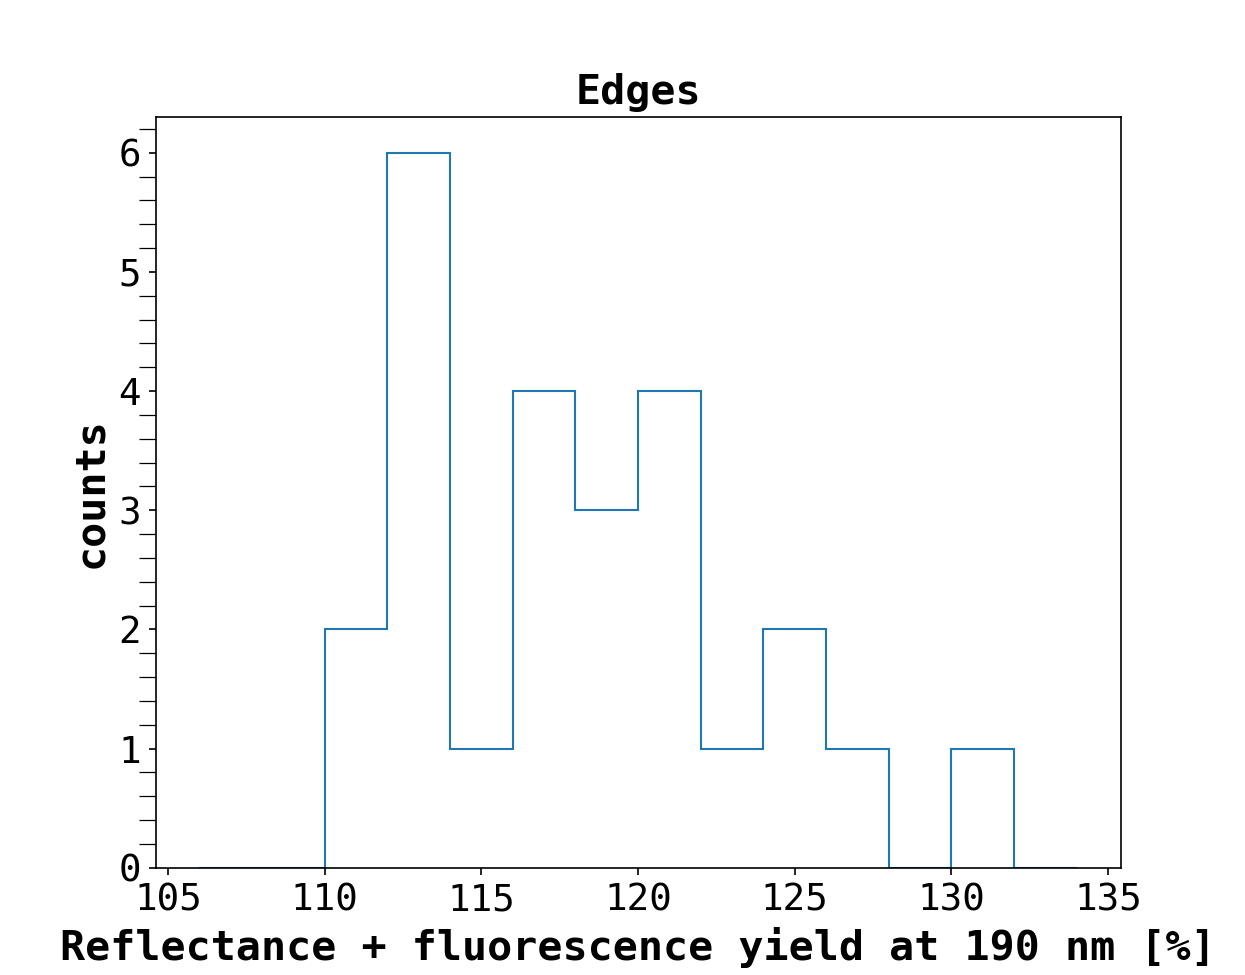

In [74]:
fig8, ax8= plt.subplots(1, 1, figsize=[8.3, 6.5], dpi=150) #14, 11], dpi=75)

# hist_content, hist_edges, _histObjects = ax8.hist(PEN_R190_Edges_ls, bins=10, histtype='step')
hist_content, hist_edges, _histObjects = ax8.hist(PEN_R190_Edges_ls, bins=np.arange(106, 136, 2), histtype='step', label='data')
ax8.set_xlabel('Reflectance + fluorescence yield at 190 nm [%]', fontsize=20)
# ax8.tick_params(axis='x', rotation=-15)
ax8.set_ylabel('counts', fontsize=20)
ax8.set_title('Edges')

In [75]:
# text_in_box = AnchoredText(f"statistics = {int(np.sum(hist_content))}" '\n$\mu$' f' = {np.mean(PEN_R190_Edges_ls):.3f}' '\n$\sigma$' f' = {np.std(PEN_R190_Edges_ls):.3f}',
#                         #    '\n$\\chi^{2}/\\nu$' f" = {red_chisqr_value:.2f}" '\n$\mu$' f' = {fitted_parameters[0]:.3f}' '\n$\sigma$' f' = {fitted_parameters[1]:.3f}',\
#                                         prop=dict(size=18), loc='upper center')
# ax8.add_artist(text_in_box)

In [76]:
cost_func = ExtendedBinnedNLL(hist_content, hist_edges, f_gauss, verbose=0, use_pdf='numerical')
# cost_func = ExtendedBinnedNLL(hist_content, hist_edges, cdf_gauss, verbose=0)

# p0_input = [120, 4.9]
p0_input = [120, 4.9, 10]
p0_input[2] = int(np.sum(hist_content))

m8 = Minuit(cost_func, *p0_input)
m8.limits["f_mean"] = (90, None)
m7.limits["f_sigma"] = (0, None)
# m8.limits["f_k"] = (None, 10)
m8.fixed["f_k"] = True

In [77]:
m8.migrad();

In [78]:
m8.hesse()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 12.85 (χ²/ndof = 1.1)      │              Nfcn = 49               │
│ EDM = 7.05e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│      No parameters at limit      │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬─────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name    │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼─────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ f_mean  │   118.0   │    1.2    │            │            │   90    │         │       │
│ 1 │ f_sigma │    5.4    │    0.9    │            │            │         │         │       │
│ 2 │ f_k     │   25.00   │   0.25    │            │            │         │         │  yes  │
└───┴─────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌─────────┬─────────────────────────┐
│         │  f_mean f_sigma     f_k │
├─────────┼─────────────────────────┤
│  f_mean │    1.32    -0.1     0.0 │
│ f_sigma │    -0.1   0.871     0.0 │
│     f_k │     0.0     0.0       0 │
└─────────┴─────────────────────────┘

In [79]:
# rng = np.random.default_rng(1)

x_samples = rng.normal(m8.values[0], m8.values[1], size=int(1e7))
x_hist_content, hist_edges = np.histogram(x_samples, bins=hist_edges);
hist_centres = hist_edges + 0.5*(hist_edges[1]-hist_edges[0])
ax8.plot(hist_centres[:-1], x_hist_content*m8.values[2]/np.sum(x_hist_content), color='red', label='fit')
# ax8.legend(loc='upper left')
## Manually read from m8
## TODO make it dynamic
red_chisqr_value = 1.1
fitted_parameter = np.array(m8.values)
text_in_box2 = AnchoredText(f"statistics = {int(np.sum(hist_content))}" '\np-value = 'f"{calc_pvalue(PEN_R190_Edges_ls, m8):.3f}"'\n$\mu$' f' = {fitted_parameter[0]:.3f}' '\n$\sigma$' f' = {fitted_parameter[1]:.3f}',\
                                        prop=dict(size=14), loc='center right', bbox_to_anchor=(1.0, 0.58), bbox_transform=ax7.transAxes)
text_in_box2.patch.set_alpha(0.1)
ax8.add_artist(text_in_box2)
ax8.legend(loc='upper right', fontsize=14)#20)

Adjusted p-value: 0.25


/tmp/ipykernel_2948194/3856201222.py:19: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  p_value = anderson_ksamp([np.array(data_ls), simulated_data]).significance_level;


In [80]:
# fig8.savefig("../reflectance_DS_edges.png")

In [81]:
calc_pvalue(PEN_R190_Edges_ls, m8)

Adjusted p-value: 0.25


/tmp/ipykernel_2948194/3856201222.py:19: UserWarning: p-value capped: true value larger than 0.25. Consider specifying `method` (e.g. `method=stats.PermutationMethod()`.)
  p_value = anderson_ksamp([np.array(data_ls), simulated_data]).significance_level;


0.25

<p>###########################################################################################################################</p>

<h2 style='color:magenta'> Tables: All DS samples and 2PAC </h2>

In [82]:
# - table with for each sample type (2pac, a, b, c, a+b+c jointly) : mean, standard deviation (sigma), and Standard Error of the Mean (standard deviation / sqrt (number of samples) or from the fit )

In [83]:
PEN_R190_df = pd.DataFrame(columns=['A', 'B', 'C', '2PAC'])
label_ls = ['A', 'B', 'B', 'C', '2PAC']
filename_pattern_ls = ['pen_argset_A*.txt', 'pen_argset_B*.txt', 'pen_argset_otherB_*.txt', 'pen_argset_C*.txt', 'pen_teonex_Q51_old_*.txt']

for index_file, filename_pattern in enumerate(filename_pattern_ls):
    datafile_path_ls = glob(path.join(data_dir, filename_pattern))
    cntr = 0
    for index_d, datafile_path in enumerate(datafile_path_ls):
        datafile = pd.read_csv(datafile_path, delimiter="\t", decimal=",", skiprows=[0,1], names=['wavelength', 'R'])
        PEN_R190_df.loc[cntr, label_ls[index_file]] = datafile['R'][datafile['wavelength']==190].iloc[0]
        cntr += 1

In [84]:
# del PEN_R190_df
PEN_R190_df

,A,B,C,2PAC
0,117.2243,117.6801,113.9235,115.914
1,114.5408,124.4613,116.7502,111.6018
2,110.2653,126.8221,110.3364,113.8491
3,117.1709,122.6416,116.2878,114.9573
4,122.246,122.9179,120.5388,NaN
5,121.125,117.5844,119.1593,NaN
6,113.3084,NaN,121.0772,NaN
7,112.5161,NaN,118.0805,NaN
8,125.8703,NaN,124.1298,NaN
9,113.9252,NaN,113.7941,NaN


In [85]:
# a
print(f"mean {np.mean(PEN_R190_df['A']):.3f}")
print(f"std {np.std(PEN_R190_df['A']):.3f}")
print(f"standard error of the mean: {np.divide(np.std(PEN_R190_df['A']), np.sqrt(PEN_R190_df['A'].shape[0])):.3f}")

mean 118.626
std 5.839
standard error of the mean: 1.508


In [86]:
# b
# PEN_R190_df['B'][PEN_R190_df['B'].notna()]
print(f"mean {np.mean(PEN_R190_df['B'][PEN_R190_df['B'].notna()]):.3f}")
print(f"std {np.std(PEN_R190_df['B'][PEN_R190_df['B'].notna()]):.3f}")
print(f"standard error of the mean: {np.divide(np.std(PEN_R190_df['B'][PEN_R190_df['B'].notna()]), np.sqrt(PEN_R190_df['B'][PEN_R190_df['B'].notna()].shape[0])):.3f}")

mean 122.018
std 3.384
standard error of the mean: 1.382


In [87]:
# c
# PEN_R190_df['C'][PEN_R190_df['C'].notna()]
print(f"mean {np.mean(PEN_R190_df['C'][PEN_R190_df['C'].notna()]):.3f}")
print(f"std {np.std(PEN_R190_df['C'][PEN_R190_df['C'].notna()]):.3f}")
print(f"standard error of the mean: {np.divide(np.std(PEN_R190_df['C']), np.sqrt(PEN_R190_df['C'].shape[0])):.3f}")

mean 117.408
std 3.858
standard error of the mean: 0.996


In [88]:
# a + b + c
print(f"mean: {np.mean( pd.concat([PEN_R190_df['C'][PEN_R190_df['C'].notna()], PEN_R190_df['B'][PEN_R190_df['B'].notna()], PEN_R190_df['A'] ])):.3f}")
print(f"std: {np.std( pd.concat([PEN_R190_df['C'][PEN_R190_df['C'].notna()], PEN_R190_df['B'][PEN_R190_df['B'].notna()], PEN_R190_df['A'] ]) ):.3f} ")
print(f"standard error of the mean: {np.divide(np.std( pd.concat([PEN_R190_df['C'][PEN_R190_df['C'].notna()], PEN_R190_df['B'][PEN_R190_df['B'].notna()], PEN_R190_df['A'] ]) ), np.sqrt(pd.concat([PEN_R190_df['C'][PEN_R190_df['C'].notna()], PEN_R190_df['B'][PEN_R190_df['B'].notna()], PEN_R190_df['A'] ]).shape[0])):.3f} ")

mean: 118.889
std: 5.114 
standard error of the mean: 0.918 


In [89]:
# 2PAC
# PEN_R190_df['2PAC'][PEN_R190_df['2PAC'].notna()]
print(f"mean {np.mean(PEN_R190_df['2PAC'][PEN_R190_df['2PAC'].notna()]):.3f}")
print(f"std {np.std(PEN_R190_df['2PAC'][PEN_R190_df['2PAC'].notna()]):.3f}")
print(f"standard error of the mean: {np.divide(np.std(PEN_R190_df['2PAC']), np.sqrt(PEN_R190_df['2PAC'].shape[0])):.3f}")

mean 114.081
std 1.607
standard error of the mean: 0.415


<p>###########################################################################################################################</p>

<h2 style='color:magenta'> Tables: Top and Bottom </h2>

In [91]:
surface_R190_df = pd.DataFrame(columns=['Top', 'Bottom'])
label_ls = ['Top', 'Bottom']
filename_pattern_ls = ['*_Top*.txt', '*_Bottom*.txt']

for index_file, filename_pattern in enumerate(filename_pattern_ls):
    datafile_path_ls = glob(path.join(data_dir, filename_pattern))
    cntr = 0
    for index_d, datafile_path in enumerate(datafile_path_ls):
        datafile = pd.read_csv(datafile_path, delimiter="\t", decimal=",", skiprows=[0,1], names=['wavelength', 'R'])
        surface_R190_df.loc[cntr, label_ls[index_file]] = datafile['R'][datafile['wavelength']==190].iloc[0]
        cntr += 1

In [92]:
surface_R190_df

,Top,Bottom
0,113.9235,116.7502
1,122.246,121.125
2,110.3364,116.2878
3,125.8703,120.5388
4,119.1593,121.5093
5,113.0085,121.0772
6,124.1298,126.944
7,113.7941,118.0805
8,NaN,130.9586


In [93]:
print(f"Top mean: {np.mean(surface_R190_df['Top']):.3f}")

Top mean: 117.808


In [94]:
print(f"Top std: {np.std(surface_R190_df['Top']):.3f}")

Top std: 5.438


In [95]:
print(f"Top standard error of the mean: {np.divide(np.std(surface_R190_df['Top']), np.sqrt(surface_R190_df['Top'].notna().sum())):.3f}")

Top standard error of the mean: 1.923


In [96]:
print(f"Bottom mean: {np.mean(surface_R190_df['Bottom']):.3f}")

Bottom mean: 121.475


In [97]:
print(f"Bottom std: {np.std(surface_R190_df['Bottom']):.3f}")

Bottom std: 4.494


In [98]:
print(f"Bottom standard error of the mean: {np.divide(np.std(surface_R190_df['Bottom']), np.sqrt(surface_R190_df['Bottom'].notna().sum())):.3f}")

Bottom standard error of the mean: 1.498


<p>###########################################################################################################################</p>

<h2 style='color:magenta'> Tables: Edges and Centre </h2>

In [99]:
location_R190_df = pd.DataFrame(columns=['Edges', 'Centre'])
label_ls = ['Edges', 'Centre', 'Centre', 'Edges']
filename_pattern_ls =  ['pen_argset_A*.txt', 'pen_argset_B*.txt', 'pen_argset_otherB_*.txt', 'pen_argset_C*.txt']

for index_file, filename_pattern in enumerate(filename_pattern_ls):
    datafile_path_ls = glob(path.join(data_dir, filename_pattern))
    cntr = 0
    for index_d, datafile_path in enumerate(datafile_path_ls):
        datafile = pd.read_csv(datafile_path, delimiter="\t", decimal=",", skiprows=[0,1], names=['wavelength', 'R'])
        location_R190_df.loc[cntr, label_ls[index_file]] = datafile['R'][datafile['wavelength']==190].iloc[0]
        cntr += 1

In [100]:
location_R190_df

,Edges,Centre
0,113.9235,117.6801
1,116.7502,124.4613
2,110.3364,126.8221
3,116.2878,122.6416
4,120.5388,122.9179
5,119.1593,117.5844
6,121.0772,NaN
7,118.0805,NaN
8,124.1298,NaN
9,113.7941,NaN


In [101]:
print(f"Edges mean: {np.mean(location_R190_df['Edges']):.3f}")

Edges mean: 119.018


In [102]:
print(f"Edges std: {np.std(location_R190_df['Edges']):.3f}")

Edges std: 5.308


In [103]:
print(f"Edges standard error of the mean: {np.divide(np.std(location_R190_df['Edges']), np.sqrt(location_R190_df['Edges'].notna().sum())):.3f}")

Edges standard error of the mean: 1.370


In [104]:
print(f"Centre mean: {np.mean(location_R190_df['Centre']):.3f}")

Centre mean: 122.018


In [105]:
print(f"Centre std: {np.std(location_R190_df['Centre']):.3f}")

Centre std: 3.384


In [106]:
print(f"Centre standard error of the mean: {np.divide(np.std(location_R190_df['Centre']), np.sqrt(location_R190_df['Centre'].notna().sum())):.3f}")

Centre standard error of the mean: 1.382


<p>###########################################################################################################################</p>

<h2 style='color:lightgreen; text-align:center'> Multiple samples: average spectra; full range </h2>

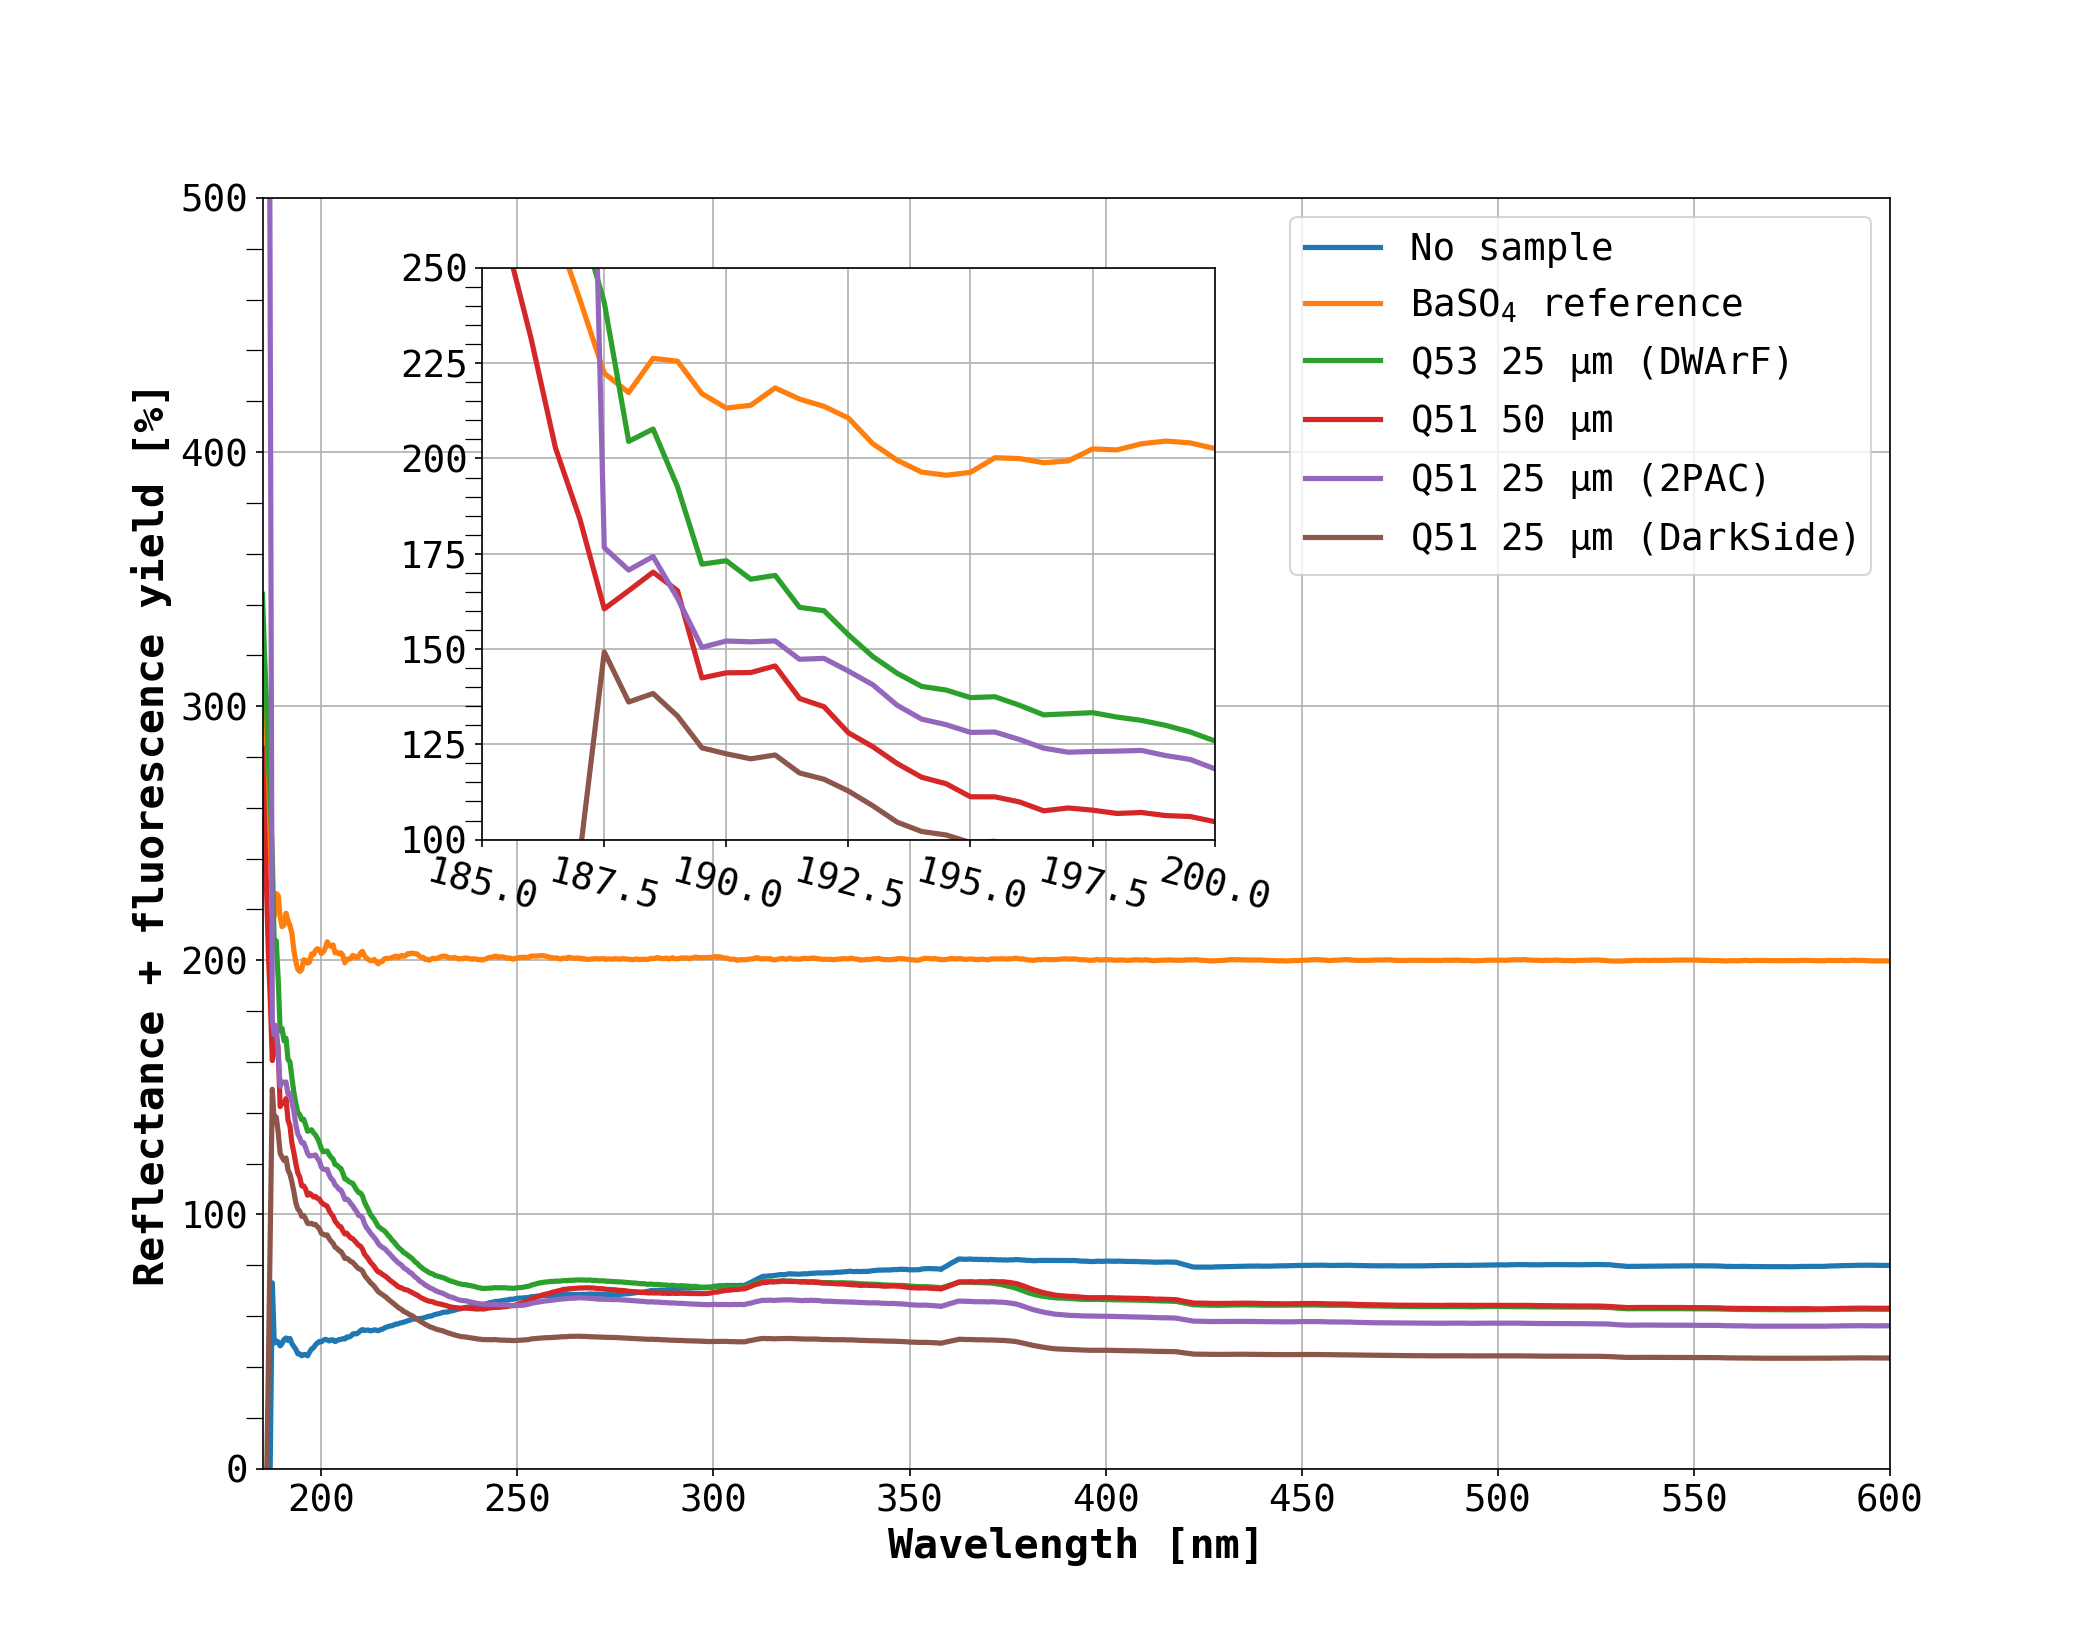

In [166]:
# spec_data = np.zeros(datafile.shape[0])
spec_data = datafile.copy() # temp
# spec_data.loc[:, 'R'] = 0
plt.close(fig9)

filename_pattern_ls = ['no_sample_*.txt', 'reference_BaSO4_*.txt', 'PEN_Q53_UZH_*.txt', 'PEN_Q51_50um_*.txt', 'pen_teonex_Q51_old*.txt', 'pen_argset_*.txt']#'pen_argset_A_centre_front.txt']
wls_label_ls = ['No sample', 'BaSO$_{4}$ reference', 'Q53 25 $\\mu$m (DWArF)', 'Q51 50 $\\mu$m', 'Q51 25 $\\mu$m (2PAC)', 'Q51 25 $\\mu$m (DarkSide)']
colour_ls = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5']
# del fig9, ax9, ax_inset9
fig9, ax9, ax_inset9 = create_fig_with_inset(2)
#####
for index_file, filename_pattern in enumerate(filename_pattern_ls):
    datafile_path_ls = glob(path.join(data_dir, filename_pattern))
    spec_data.loc[:, 'R'] = 0
    for index_d, datafile_path in enumerate(datafile_path_ls):
        datafile = pd.read_csv(datafile_path, delimiter="\t", decimal=",", skiprows=[0,1], names=['wavelength', 'R'])
        # spec_data['R'] += datafile['R']
        spec_data.loc[:, 'R'] += datafile.loc[:, 'R']
#####
# 
        # add_line(fig9, ax9, ax_inset9, datafile, wls_label_ls[index_file], colorstr=colour_ls[index_file])
    spec_data.loc[:, 'R'] = spec_data.loc[:, 'R']/index_d#/cntr
    add_line(fig9, ax9, ax_inset9, spec_data, wls_label_ls[index_file], colorstr=colour_ls[index_file])

In [167]:
fig9.savefig('../plots/reflectance_all_samples_average.png')